# **ECE1512 Project_A Preperation Part 1: 1-D Digit Classification**

## Drive Mounting

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir(r'/content/drive/MyDrive/ECE1512_ProjectA/Project_A_Supp')  # Change the directory to torchRay-master folder

## Requirements

In [ ]:
import os
import numpy as np
import pandas as pd
import requests
import scipy
import pickle
from scipy.ndimage.filters import gaussian_filter
from scipy.interpolate import interp1d
import tensorflow
import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Flatten
from keras import regularizers
import keras.backend as K
from keras.models import load_model
from tensorflow.core.util import event_pb2
from tensorflow.python.lib.io import tf_record
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf

In [ ]:
#@title MNIST-1D utils

# transformations of the templates which will make them harder to classify
def pad(x, padding):
    low, high = padding
    p = low + int(np.random.rand()*(high-low+1))
    return np.concatenate([x, np.zeros((p))])

def shear(x, scale=10):
    coeff = scale*(np.random.rand() - 0.5)
    return x - coeff*np.linspace(-0.5,.5,len(x))

def translate(x, max_translation):
    k = np.random.choice(max_translation)
    return np.concatenate([x[-k:], x[:-k]])

def corr_noise_like(x, scale):
    noise = scale * np.random.randn(*x.shape)
    return gaussian_filter(noise, 2)

def iid_noise_like(x, scale):
    noise = scale * np.random.randn(*x.shape)
    return noise

def interpolate(x, N):
    scale = np.linspace(0,1,len(x))
    new_scale = np.linspace(0,1,N)
    new_x = interp1d(scale, x, axis=0, kind='linear')(new_scale)
    return new_x

def transform(x, y, args, eps=1e-8):
    new_x = pad(x+eps, args.padding) # pad
    new_x = interpolate(new_x, args.template_len + args.padding[-1])  # dilate
    new_y = interpolate(y, args.template_len + args.padding[-1])
    new_x *= (1 + args.scale_coeff*(np.random.rand() - 0.5))  # scale
    new_x = translate(new_x, args.max_translation)  #translate
    
    # add noise
    mask = new_x != 0
    new_x = mask*new_x + (1-mask)*corr_noise_like(new_x, args.corr_noise_scale)
    new_x = new_x + iid_noise_like(new_x, args.iid_noise_scale)
    
    # shear and interpolate
    new_x = shear(new_x, args.shear_scale)
    new_x = interpolate(new_x, args.final_seq_length) # subsample
    new_y = interpolate(new_y, args.final_seq_length)
    return new_x, new_y

def get_dataset_args(as_dict=False):
    arg_dict = {'num_samples': 5000,
            'train_split': 0.8,
            'template_len': 12,
            'padding': [36,60],
            'scale_coeff': .4, 
            'max_translation': 48,
            'corr_noise_scale': 0.25,
            'iid_noise_scale': 2e-2,
            'shear_scale': 0.75,
            'shuffle_seq': False,
            'final_seq_length': 40,
            'seed': 42,
            'url': 'https://github.com/greydanus/mnist1d/raw/master/mnist1d_data.pkl'}
    return arg_dict if as_dict else ObjectView(arg_dict)


def to_pickle(thing, path): # save something
    with open(path, 'wb') as handle:
        pickle.dump(thing, handle, protocol=4)


def from_pickle(path): # load something
    thing = None
    with open(path, 'rb') as handle:
        thing = pickle.load(handle)
    return thing

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

# basic 1D templates for the 10 digits
def get_templates():
    d0 = np.asarray([5,6,6.5,6.75,7,7,7,7,6.75,6.5,6,5])
    d1 = np.asarray([5,3,3,3.4,3.8,4.2,4.6,5,5.4,5.8,5,5])
    d2 = np.asarray([5,6,6.5,6.5,6,5.25,4.75,4,3.5,3.5,4,5])
    d3 = np.asarray([5,6,6.5,6.5,6,5,5,6,6.5,6.5,6,5])
    d4 = np.asarray([5,4.4,3.8,3.2,2.6,2.6,5,5,5,5,5,5])
    d5 = np.asarray([5,3,3,3,3,5,6,6.5,6.5,6,4.5,5])
    d6 = np.asarray([5,4,3.5,3.25,3,3,3,3,3.25,3.5,4,5])
    d7 = np.asarray([5,7,7,6.6,6.2,5.8,5.4,5,4.6,4.2,5,5])
    d8 = np.asarray([5,4,3.5,3.5,4,5,5,4,3.5,3.5,4,5])
    d9 = np.asarray([5,4,3.5,3.5,4,5,5,5,5,4.7,4.3,5])
    
    x = np.stack([d0,d1,d2,d3,d4,d5,d6,d7,d8,d9])
    x -= x.mean(1,keepdims=True) # whiten
    x /= x.std(1,keepdims=True)
    x -= x[:,:1]  # signal starts and ends at 0
    
    templates = {'x': x/6., 't': np.linspace(-5, 5, len(d0))/6.,
                 'y': np.asarray([0,1,2,3,4,5,6,7,8,9])}
    return templates

def make_dataset(args=None, template=None, ):
    templates = get_templates() if template is None else template
    args = get_dataset_args() if args is None else args
    np.random.seed(args.seed) # reproducibility
    
    xs, ys = [], []
    samples_per_class = args.num_samples // len(templates['y'])
    for label_ix in range(len(templates['y'])):
        for example_ix in range(samples_per_class):
            x = templates['x'][label_ix]
            t = templates['t']
            y = templates['y'][label_ix]
            x, new_t = transform(x, t, args) # new_t transformation is same each time
            xs.append(x) ; ys.append(y)
    
    batch_shuffle = np.random.permutation(len(ys)) # shuffle batch dimension
    xs = np.stack(xs)[batch_shuffle]
    ys = np.stack(ys)[batch_shuffle]
    
    if args.shuffle_seq: # maybe shuffle the spatial dimension
        seq_shuffle = np.random.permutation(args.final_seq_length)
        xs = xs[...,seq_shuffle]
    
    new_t = new_t/xs.std()
    xs = (xs-xs.mean())/xs.std() # center the dataset & set standard deviation to 1

    # train / test split
    split_ix = int(len(ys)*args.train_split)
    dataset = {'x': xs[:split_ix], 'x_test': xs[split_ix:],
               'y': ys[:split_ix], 'y_test': ys[split_ix:],
               't':new_t, 'templates': templates}
    return dataset


In [ ]:
from mnist1d_utils import *

## Dataset

In [ ]:
dataset = make_dataset()

**Dataset:** A dictionary conaining 4000 train and 1000 test data.

Keys of the dictionary:

* 'x' : Training data.

* 'y' : Training labels.

* 'x_test' : Test data.

* 'y_test : Test labels.

* 't' : Mapping data points to spatial locations.

* 'templates' : The templates for the digits 0-9.

Text(0.5, 1.0, 'predicted class: 6')

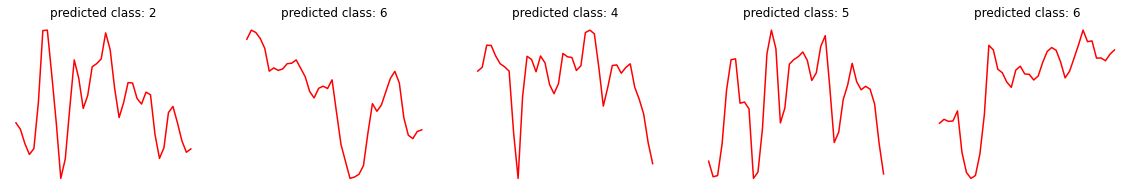

In [ ]:
#@title Show some examples from the MNIST 1-D dataset

plt.figure(figsize=(20,3))

plt.subplot(151)
plt.plot(dataset['x'][0], 'r')
plt.axis('off')
plt.title('predicted class: '+str(dataset['y'][0]))

plt.subplot(152)
plt.plot(dataset['x'][1], 'r')
plt.axis('off')
plt.title('predicted class: '+str(dataset['y'][1]))

plt.subplot(153)
plt.plot(dataset['x'][2], 'r')
plt.axis('off')
plt.title('predicted class: '+str(dataset['y'][2]))

plt.subplot(154)
plt.plot(dataset['x'][3], 'r')
plt.axis('off')
plt.title('predicted class: '+str(dataset['y'][3]))

plt.subplot(155)
plt.plot(dataset['x'][4], 'r')
plt.axis('off')
plt.title('predicted class: '+str(dataset['y'][4]))

Text(0.5, 1.0, 'predicted class: 9')

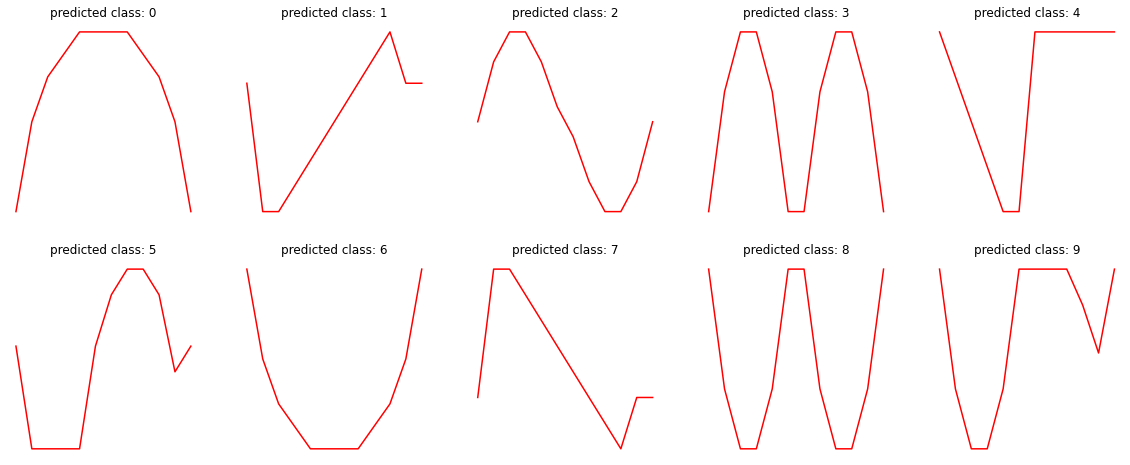

In [ ]:
#@title Show the digit templates in the MNIST 1-D dataset 

plt.figure(figsize=(20,8))

plt.subplot(251)
plt.plot(dataset['templates']['x'][0], 'r')
plt.axis('off')
plt.title('predicted class: 0')

plt.subplot(252)
plt.plot(dataset['templates']['x'][1], 'r')
plt.axis('off')
plt.title('predicted class: 1')

plt.subplot(253)
plt.plot(dataset['templates']['x'][2], 'r')
plt.axis('off')
plt.title('predicted class: 2')

plt.subplot(254)
plt.plot(dataset['templates']['x'][3], 'r')
plt.axis('off')
plt.title('predicted class: 3')

plt.subplot(255)
plt.plot(dataset['templates']['x'][4], 'r')
plt.axis('off')
plt.title('predicted class: 4')

plt.subplot(256)
plt.plot(dataset['templates']['x'][5], 'r')
plt.axis('off')
plt.title('predicted class: 5')

plt.subplot(257)
plt.plot(dataset['templates']['x'][6], 'r')
plt.axis('off')
plt.title('predicted class: 6')

plt.subplot(258)
plt.plot(dataset['templates']['x'][7], 'r')
plt.axis('off')
plt.title('predicted class: 7')

plt.subplot(259)
plt.plot(dataset['templates']['x'][8], 'r')
plt.axis('off')
plt.title('predicted class: 8')

plt.subplot(2,5,10)
plt.plot(dataset['templates']['x'][9], 'r')
plt.axis('off')
plt.title('predicted class: 9')

Saving the dataset

In [ ]:
f = open("MNIST1D.pkl","wb")
pickle.dump(dataset,f)
f.close()



---

# **ECE1512 Project_A Solution Part 1: 1-D Digit Classification**

## Task 1:1-Dimensional digit classification

### Task 1-1: Model Creation

**Creating model :**

A 1-Dimensional CNN, containing 3 convolutional layers, followed by a fully-connected output layer.

In [ ]:
##Task1-Question1
weight_decay = 5e-4
model = Sequential()
#Your code starts from here 

model.add(Conv1D(filters=25,kernel_size=5,strides=1, activation='relu',padding='same',input_shape = (40,1),
                 kernel_regularizer=tensorflow.keras.regularizers.l2(weight_decay)))

model.add(Conv1D(filters=25,kernel_size=3,strides=1, activation='relu',padding='same',
                 kernel_regularizer=tensorflow.keras.regularizers.l2(weight_decay)))

model.add(Conv1D(filters=25,kernel_size=3,strides=1, activation='relu',padding='same',
                 kernel_regularizer=tensorflow.keras.regularizers.l2(weight_decay)))

model.add(Flatten())

model.add(Dense(activation='softmax',units = 10))

##

### Task 1-2: Training the model

Compiling the model

Loss function: Cross-entropy

Optimizer: Stochastic Gradient Descent (SGD) (learning rate = 0.01)

Tensorboard: For recording the training procedure

In [ ]:
model.compile(optimizer=tensorflow.keras.optimizers.SGD(learning_rate=0.01),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x=np.expand_dims(dataset['x'], axis=-1), y=dataset['y'], validation_split=0.1, epochs=200)

Epoch 1/200
113/113 [==============================] - 1s 7ms/step - loss: 2.3118 - accuracy: 0.1250 - val_loss: 2.2914 - val_accuracy: 0.1425
Epoch 2/200
113/113 [==============================] - 1s 5ms/step - loss: 2.2367 - accuracy: 0.1789 - val_loss: 2.1813 - val_accuracy: 0.2200
Epoch 3/200
113/113 [==============================] - 1s 5ms/step - loss: 2.0415 - accuracy: 0.2292 - val_loss: 1.9538 - val_accuracy: 0.2425
Epoch 4/200
113/113 [==============================] - 1s 5ms/step - loss: 1.8552 - accuracy: 0.2786 - val_loss: 1.8341 - val_accuracy: 0.2600
Epoch 5/200
113/113 [==============================] - 1s 5ms/step - loss: 1.7669 - accuracy: 0.3092 - val_loss: 1.7562 - val_accuracy: 0.2875
Epoch 6/200
113/113 [==============================] - 1s 4ms/step - loss: 1.7176 - accuracy: 0.3244 - val_loss: 1.7006 - val_accuracy: 0.3250
Epoch 7/200
113/113 [==============================] - 1s 5ms/step - loss: 1.6719 - accuracy: 0.3397 - val_loss: 1.6578 - val_accuracy: 0.3325

### Task 1-3: Plotting the training progress

#### Task 1-3-a: Plot for loss curve and for accuracy curve

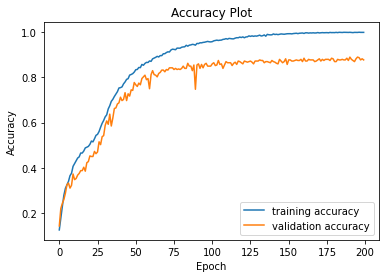

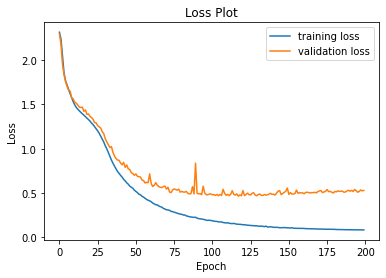

In [ ]:
## Loss And Accuracy Curve
plt.plot(history.history['accuracy'], label = 'training accuracy')
plt.plot(history.history['val_accuracy'],label = 'validation accuracy')
plt.title('Accuracy Plot')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.plot(history.history['loss'],label = 'training loss')
plt.plot(history.history['val_loss'],label = 'validation loss')
plt.title('Loss Plot')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Task 1-3-b: Overall classification accuracy on the test set

In [ ]:
## Overall Accuracy
y_pred = model.predict(np.expand_dims(dataset['x_test'], axis=-1)).argmax(axis=-1)
metrics.accuracy_score(y_pred,dataset['y_test'])

0.903

#### Task 1-3-c: Class-wise classification accuracy for all classes

In [ ]:
## Class-wise Classification Accuracy for all class
acc = []
for i in range(10):
  class_ind = np.where(dataset['y_test']==i)  
  predicted = y_pred[class_ind[0]]
  print('class: {0}, accuracy: {1}'.format(i,metrics.accuracy_score(predicted,dataset['y_test'][class_ind[0]])))

class: 0, accuracy: 0.9803921568627451
class: 1, accuracy: 0.9038461538461539
class: 2, accuracy: 0.8764044943820225
class: 3, accuracy: 0.9716981132075472
class: 4, accuracy: 0.8867924528301887
class: 5, accuracy: 0.8673469387755102
class: 6, accuracy: 0.9595959595959596
class: 7, accuracy: 0.8854166666666666
class: 8, accuracy: 0.9183673469387755
class: 9, accuracy: 0.7745098039215687


#### Task 1-3-d: Plot the classification ROC and AUC curves for each class

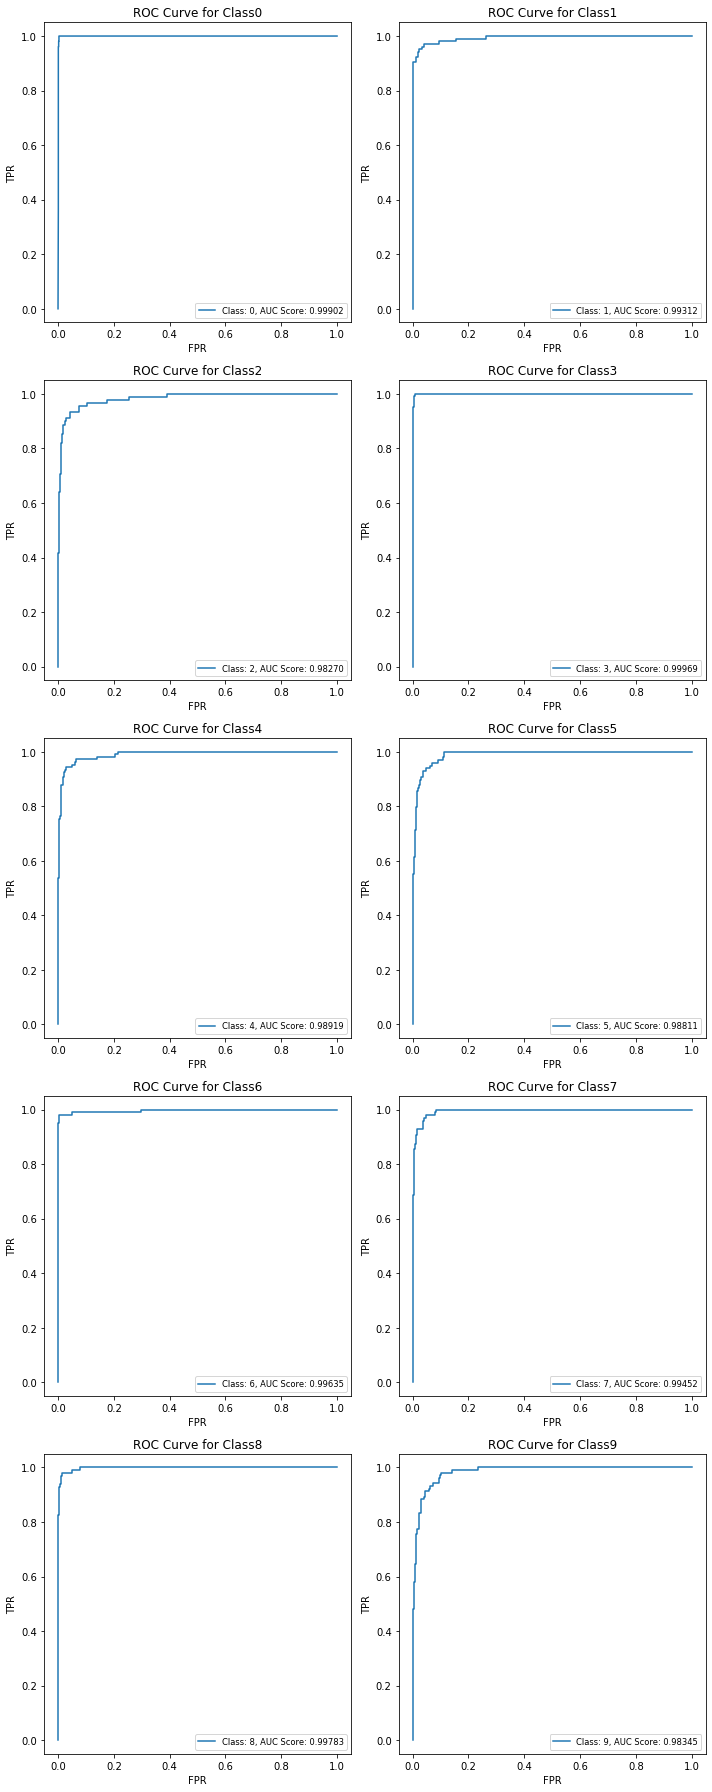

In [ ]:
#ROC and AUC Curve
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score
y_test = dataset['y_test']
lb = LabelBinarizer()
lb.fit(y_test)
y_test = lb.transform(y_test)
y_pred_transformed = lb.transform(y_pred)
y_score = model(dataset['x_test'])

fig, ax = plt.subplots(5,2,figsize=(10,25))
i = 0
for row in range(5):
  for col in range(2):
    fpr, tpr, thresholds = metrics.roc_curve(y_test[:,i].astype(int), y_score[:,i])

    ax[row,col].plot(fpr, tpr,label = "Class: {0}, AUC Score: {1:.5f}".format(i,metrics.auc(fpr,tpr)))    
    ax[row,col].legend(loc='best', fontsize = 'small')
    ax[row,col].set_title('ROC Curve for Class{}'.format(i))
    ax[row,col].set(xlabel='FPR', ylabel='TPR')
    i+=1

fig.tight_layout()

#### Task 1-3-e: Plot the normalized confusion matrix

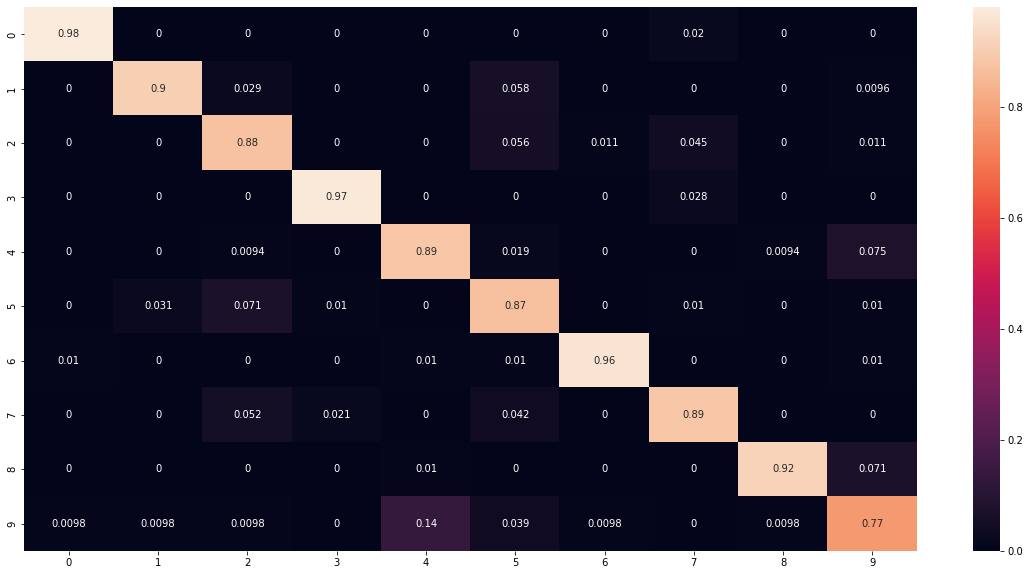

In [ ]:
## Confusion Matrix
import seaborn as sn

confusion_matrix = metrics.confusion_matrix(dataset['y_test'], y_pred,normalize='true')
df_confusion_matrix = pd.DataFrame(confusion_matrix, index = [i for i in range(0,10,1)],
                  columns = [i for i in range(0,10,1)])
plt.figure(figsize=(20,10))
sn.heatmap(df_confusion_matrix, annot=True)

#### Tassk 1-3-f: Precision, Recall, and F-1 score on the test set

In [ ]:
## Presion Recall F1 Score
print(metrics.classification_report(y_pred,dataset['y_test']))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       102
           1       0.90      0.96      0.93        98
           2       0.88      0.82      0.85        95
           3       0.97      0.97      0.97       106
           4       0.89      0.85      0.87       110
           5       0.87      0.79      0.83       107
           6       0.96      0.98      0.97        97
           7       0.89      0.89      0.89        95
           8       0.92      0.98      0.95        92
           9       0.77      0.81      0.79        98

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.90      0.90      0.90      1000



Show  some  examples  of  the  success/failure  cases  of  the  model.  Among  which  two 
classes  misclassification  happens  the  most?  Provide  your  insights  and  support  your 
answers with analytic reasons. [1.25 Marks] 

### Task 1-4:

Show some examples of the success/failure cases of the model. Among which two classes misclassification happens the most? Provide your insights and support your answers with analytic reasons.

***Answer:*** According to the classification accuracy on each single class, we can see that predictions on  number 4 and number 9 has the lowest accuracy. It happens because 4, 9 and 6 have similar patterns, which confuses the model.

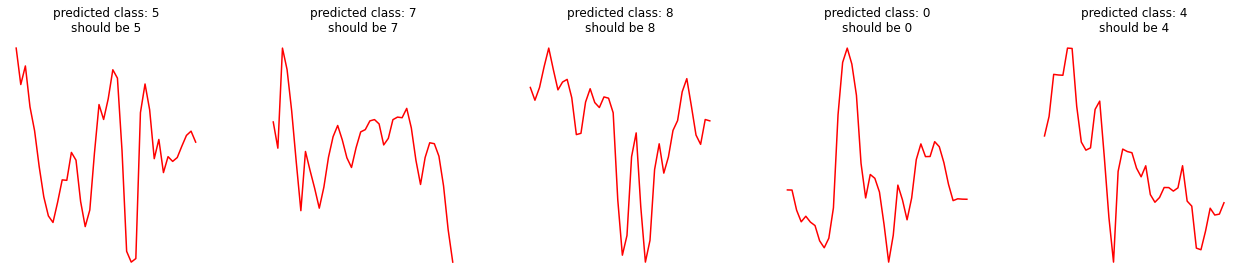

In [ ]:
#Success Cases

Success_cases = np.where(y_pred == dataset['y_test'])[0]

for i in range(5):
  plt.subplot(1,5,i+1)
  choice = np.random.choice(Success_cases)
  plt.plot(dataset['x_test'][choice], 'r')
  plt.axis('off')
  plt.title('predicted class: '+str(y_pred[choice]) + "\nshould be {0}".format(dataset['y_test'][choice]))

plt.tight_layout(rect = [0,0,3,1])


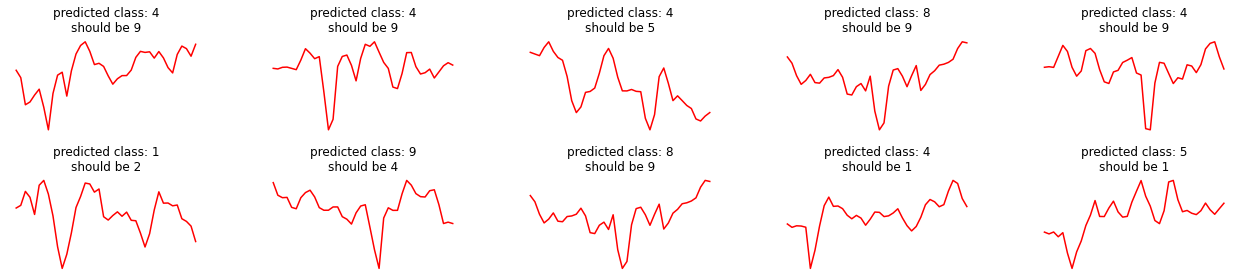

In [ ]:
#Failed Cases

Failed_cases = np.where(y_pred != dataset['y_test'])[0]

for i in range(10):
  plt.subplot(2,5,i+1)
  choice = np.random.choice(Failed_cases)
  plt.plot(dataset['x_test'][choice], 'r')
  plt.axis('off')
  plt.title('predicted class: '+str(y_pred[choice]) + "\nshould be {0}".format(dataset['y_test'][choice]))

plt.tight_layout(rect = [0,0,3,1])

## Task 2: CNN interpretation

### Task 2-1: 

Select one of the attribution methods provided in xai_utils.py and one method other than those for which codes are provided (two methods, if you do the project in a group of two). Read the paper of the selecting methods and answer the following questions for each of them.

#### Task 2-1-a: 

What knowledge gap did your two chosen attribution methods fill?

**Answer:**



*   Grad-CAM：
  *   Provide explainable extracted features in the perspective of the particular class. Specially designed for CNNs. Can be applied to a wide range of CNN model families. Have the ability to obtain the gradients and the importance of neurons of a particular class. 
*   Integrated Gradient:
  *   Most well known attribution methods cannot satisfy the two fundamental axioms which are sensitivity (sensitive to the change of baseline input feature that produces different prediction) and implementation invariance (produced explanations are always the same for a Neural Network.serving the same functionality).
*   LIME:
  *   Machine learning is a blackbox tool. Before LIME, there were rare methods to interpret and explain what the model is learning and how it achieves the desired goal. LIME learns around the local prediction to provide representative instances to explain the model and to increase the reliability of the model. It helps people understand what the meachin has learnt to make such predictions.









What novelty did they contribute compared to their prior methods?

**Answer:**



*   Grad-CAM：
  *   Instead of replacing the fully connected layer with a convolutional layer and a global average pooling in the prior method CAM, Grad CAM does not change the network architecture. It combines the feature map with feature gradients of the class. This enables the model to provide explinable extracted features for the particular class.
*   Integrated Gradient:
  *   Since the attribution of pixels is hard to evaluate empirically (e.g. perturbation method cannot  differentiate artifacts), the integrated gradient is developed with an axiomatic approach that satisfies both sensitivity and implementation invariance using the path methods.
*   LIME:
  *   LIME faithfully interprets the model prediction by locally learning around the predictions of the interpretable models [6].  It explains the instances to help to increase the model reliability by optimizing its sub modules. Fidelity-Interpretability trade-off, it minimizes the loss of fidelity function and model complexity.







#### Task 2-1-b: Explain in full detail the methodologies of your selected methods

**Answer:**



*   Grad-CAM:
  *   This method first calculates the gradient of the class with respect to the final feature map Ak. Then the method calculates the average gradient weight α and then multiplies with the Ak. The Grad-CAM is computed by using the ReLu activation on the the sum of the multiplication of α and Ak. Then based on the Gram-Cam value, it will generate a heatmap indicating the important pixels area of the prediting class.

*   Integrated Gradients:
  *   Overall, Integrated Gradients considered the straight path from the baseline image (a whole-black image) to the actual image, and computed and cumulated the gradients along the path. More specifically, a baseline image is built and then interpolated between the original image and baseline image. Meanwhile, gradients are calculated on each small interpolation and accumulate. The pixels which have a stronger effect on predictions will receive more attributions. Eventually, we rescale the integrated gradients to the size of the image.

*   LIME:
  *   The LIME method is based on solving the optimization problem (Fidelity-Interpretability Trade-off). It produces the local approximation of the instances from the interpretable model.  The optimization equation is listed below from Ribeiro et al.[6]:
> ε(x) = argmin L(f, g , πx) + Ω(g)

  *   Where L is the loss of fidelity function, f is the model being explained, g is the model explanation, πx is the approximate measure of instance z to instance x, which measure the locality around x, Ω(g) is the model complexity.[6]



#### Task 2-1-c: 

Discuss the main advantages and disadvantages of your selected methods. Do you think these methods can concretely interpret the target model in difficult scenarios (e.g., when the target model is a deep CNN or the input contains a high amount of texture or noise)? Do you think your selected methods can analyze and inspect the cases of misclassification by the target model? Why?

**Answer:**
*   Grad-CAM:
  *   Advantages
      *   High resolution in visualization
      *   Visualization is able to differentiate classes
      *   Adversarial perturbation robustness
      *   Model faithfulness
      *   Help model generalization
  *   Disadvantages
      *   Can not localize multiple objects from the same class
      *   May result in signal loss during forward and backward pass
  *   Concretely interpret the target model in difficult scenarios?
      *   Yes, Selvaraju et al. [1] demonstrated the adversarial images with high probability to a not presented class and low probability to the presented class in the pretrained VGG-16 ImageNet. The result showed that the Grad-CAM is robust in the deep neural network and with noisy data.
 *   Analyze and inspect the cases of misclassification by the target model? Why?
      *   Yes, Grad-CAM can analyze and inspect the cases of misclassification by the target model. Since Selvaraju et al. [1] also demonstrated the Grad-CAM in the failure prediction of the VGG-16 network. The predictions are inaccurate because of the ambiguities inherent in the model. The Grad-CAM visualizes the features that the inaccurate prediction is based on. It can help to explain that the incorrect predictions have reasonable interpretations.

*   Integrated Gradients:
  *   Advantages
      *   Satisfy the two axioms for Deep Neural Network’s Attribution which rule out  the artifacts.
      *   No instrumentation on the network is needed, only a few calls on the gradient operation is required for this method.
      *   Gives an ease of applicability on various neural networks including text and image networks.
  *   Disadvantages
      *   Only provides specific attribution for specific sample without any global  identification of significant features for a class of interest [4]
      *   Linear path may lead to attribution artifact in the cases of high-dimensional dataset where data may lie in non-linear structure. [4]
      *   Frequently produces noisy attributions in non-related regions leading to confusion.[5]
  *   Concretely interpret the target model in difficult scenarios?
      *   No, it is due to the intrinsic mechanism of integrated gradients. Since the final visual representation is calculated in an accumulated manner of all the gradients along the linear path. Many literatures have shown the noise of pixel attribution [5] using integrated gradients. In the cases of noisy/high-dimensional data, the noise of integrated gradients will accumulate further, leading to a final visual representation that reveals few information
  *   Analyze and inspect the cases of misclassification by the target model? Why?
      *   Yes, integrated gradient is able to analyze and inspect the cases of misclassification. Since integrated gradient is model-specific and input-specific, no matter if the model classifies the picture successfully or unsuccessfully, it will always point out the area of where the model focuses, which can be used for later diagnostics.

*   LIME:
  *   Advantages:
      *   It can not only explain the classification model prediction but also explains the regression model.
      *   Can be apply on different data type such as tabular data, text and images [7]
      *   Can be used  to explain many machine learning models, not only CNN. For example, SVM, decision tree, KNN and so on
      *   The measure of fidelity explains the reliability of instance predictions from the black box machine learning model [7]
  *   Disadvantages:
      *   The ability of explanation for LIME is susceptible to kernel width, need to be fine tuned in application [7]
      *   Gaussian distribution is used to sample the data, it does not check the features correlation. May lead to failure learning the local instance explanation [7]
  *   Concretely interpret the target model in difficult scenarios?
      *   Yes, Ribeiro et al.[6] have applied LIME in a deep neural network for image classification. An example is given on an image of a dog playing guitar. The top 3 classes are explained with LIME interpretation, the highlighted region for each prediction is reasonable and explains the relative features that the prediction is based on. Therefore, we consider that LIME can concretely interpret the target model in difficult scenarios.
  *   Analyze and inspect the cases of misclassification by the target model? Why?
      *   Yes, LIME locally learns around the instance predictions by optimizing the fidelity and interpretability. In the given example of image classification on the image of a dog playing guitar from Ribeiro et al.[6]. There is an incorrect prediction of electric guitar. The LIME method successfully explains the relative feature the prediction is based on. The image shows that the highlighted feature is actually reasonable for the misclassified prediction.






### Task 2-2: 
Apply your selected method(s) on the CNN trained on the MNIST 1-D dataset, taking different inputs

In [ ]:
from xai_utils import *

Take a test sample

In [ ]:
x_test = dataset['x_test']
y_test = dataset['y_test']

Give the input to the model (Prediction)

In [ ]:
index = int(np.floor(np.random.rand()*1000))
input = np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)
label = y_test[index]
print('Correct digit: '+str(label))
print('Predicted digit: '+str(np.argmax(model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy())))
print('Confidence score for the correct label: '+str(model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy()[0,label]))

Correct digit: 3
Predicted digit: 3
Confidence score for the correct label: 0.9999933


SISE (Semantic Input Sampling for Explanation)

In [ ]:
explanation = SISE(input, model, label, [['conv1d_2']], grad_thr=0.)

Text(0.5, 1.0, 'Highlighted input region (by the SISE algorithm)')

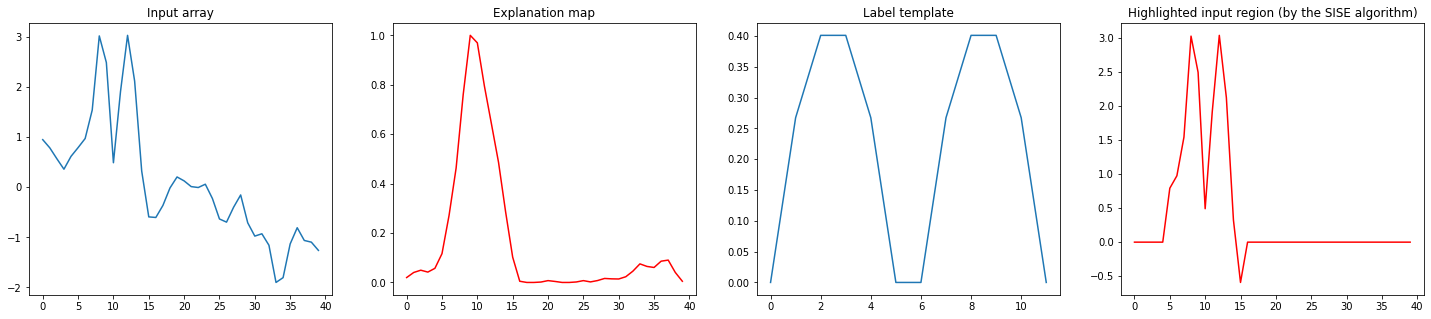

In [ ]:
threshold = np.sort(explanation[:,0])[-12]

plt.figure(figsize=(25,5))

plt.subplot(1,4,1)
plt.plot(input[0])
plt.title('Input array')

plt.subplot(1,4,2)
plt.plot(explanation, 'r')
plt.title('Explanation map')

plt.subplot(1,4,3)
plt.plot(dataset['templates']['x'][label])
plt.title('Label template')

plt.subplot(1,4,4)
plt.plot((input[0]*(explanation>threshold)), 'r')
plt.title('Highlighted input region (by the SISE algorithm)')

#### Task 2-2-a:

For each given input, your output should be a 1-dimensional explanation map that scores the input features based on their contribution to the model’s prediction.

**Model 1: Grad-CAM**

Code provided in the project material

In [ ]:
from scipy.ndimage.interpolation import zoom

def grad_cam(input_model, image, layer_name):
    cls = np.argmax(input_model.predict(image))
    def normalize(x):
        """Utility function to normalize a tensor by its L2 norm"""
        return (x + 1e-10) / (K.sqrt(K.mean(K.square(x))) + 1e-10)
    """GradCAM method for visualizing input saliency."""
    y_c = input_model.output
    conv_output = input_model.get_layer(layer_name).output
    feedforward1 = keras.models.Model([input_model.input], [conv_output, y_c])
    with tf.GradientTape() as tape:
        ff_results=feedforward1([image])
        all_fmap_masks, predictions = ff_results[0], ff_results[-1]
        loss = predictions[:, cls]
    grads_val = tape.gradient(loss, all_fmap_masks)
    if len(image.shape)==3:
        axis=(0, 1)
    elif len(image.shape)==4:
        axis=(0, 1, 2)
    weights = np.mean(grads_val, axis=axis)
    cam = np.dot(all_fmap_masks[0], weights)
    #print (cam)
    H,W= image.shape[1:3]
    cam = np.maximum(cam, 0)
    #cam = resize(cam, (H, W))
    cam = zoom(cam,H/cam.shape[0])
    #cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    return cam

In [ ]:
input = np.expand_dims(np.expand_dims(x_test[0], axis=0), axis=-1)

Text(0.5, 1.0, 'Highlighted input region (by the  algorithm)')

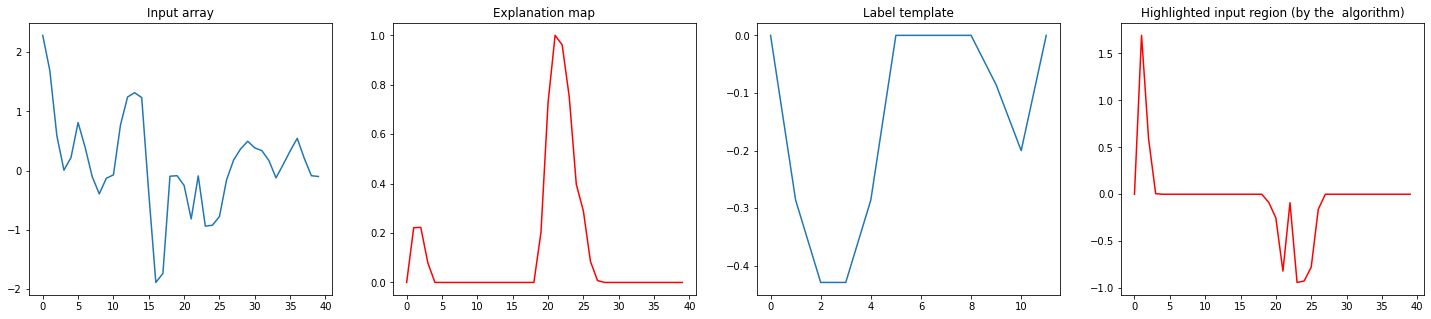

In [ ]:
threshold = np.sort(explanation)[-12]

plt.figure(figsize=(25,5))

plt.subplot(1,4,1)
plt.plot(input[0])
plt.title('Input array')

plt.subplot(1,4,2)
plt.plot(explanation, 'r')
plt.title('Explanation map')

plt.subplot(1,4,3)
plt.plot(dataset['templates']['x'][label])
plt.title('Label template')

plt.subplot(1,4,4)
plt.plot((input[0,:,0]*(explanation>threshold)), 'r')
plt.title('Highlighted input region (by the  algorithm)')


Correct digit: 0
Predicted digit: 0
Confidence score for the correct label: 0.7611122


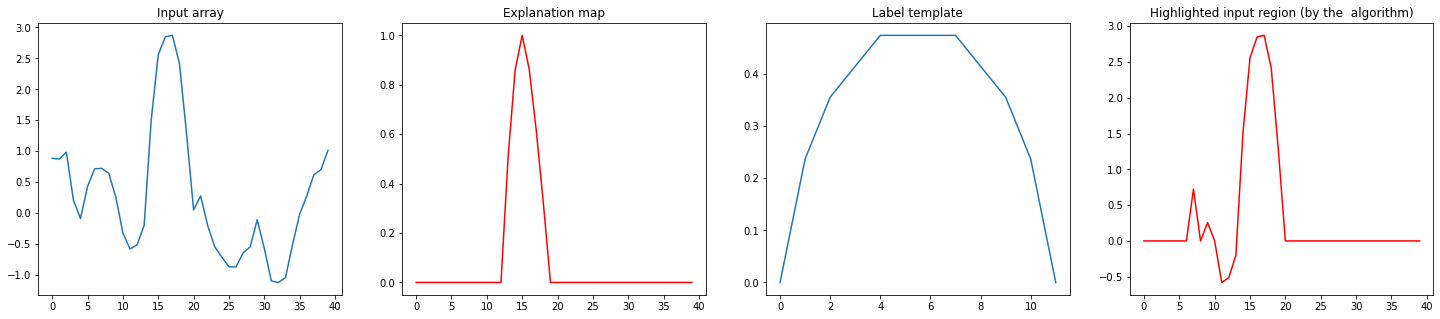


Correct digit: 1
Predicted digit: 9
Confidence score for the correct label: 0.0020318


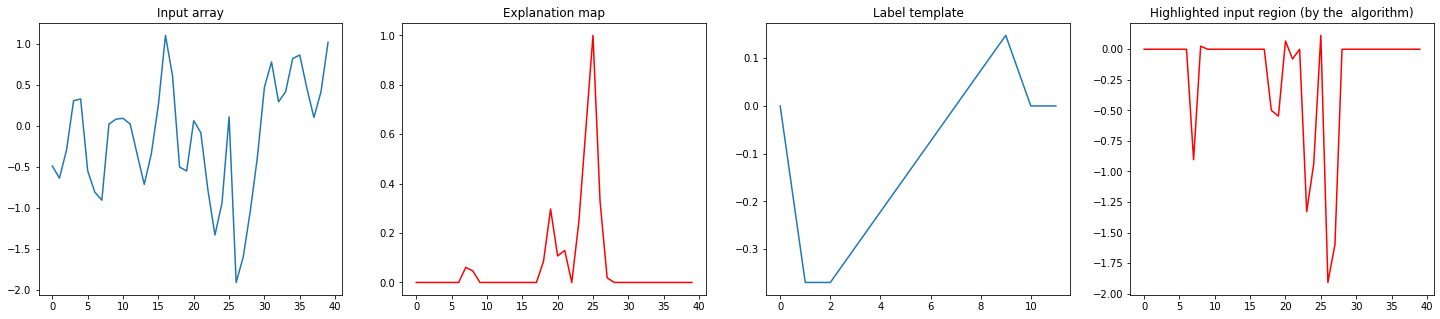


Correct digit: 2
Predicted digit: 2
Confidence score for the correct label: 0.97238916


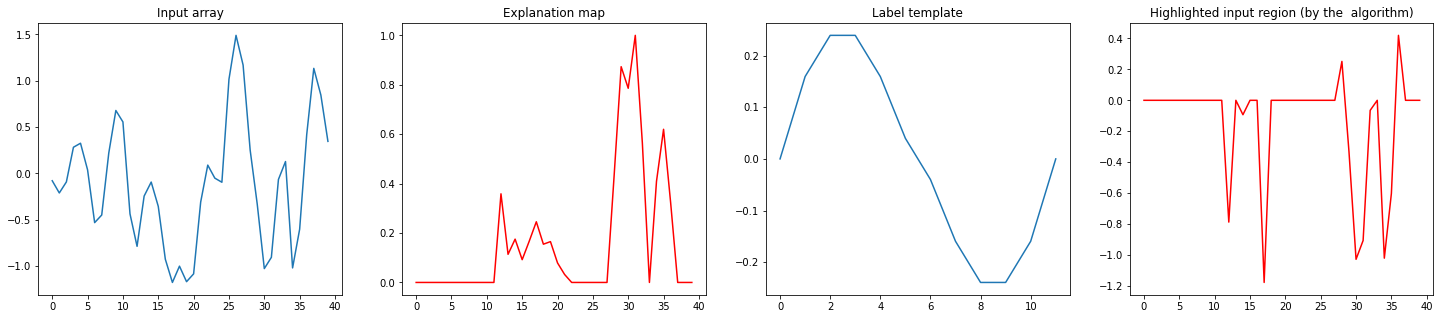


Correct digit: 3
Predicted digit: 3
Confidence score for the correct label: 1.0


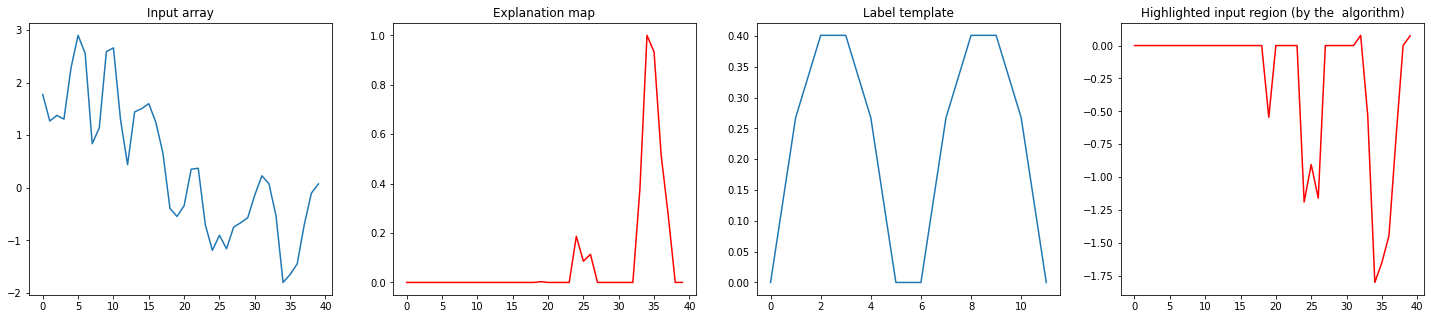


Correct digit: 4
Predicted digit: 4
Confidence score for the correct label: 0.98805517


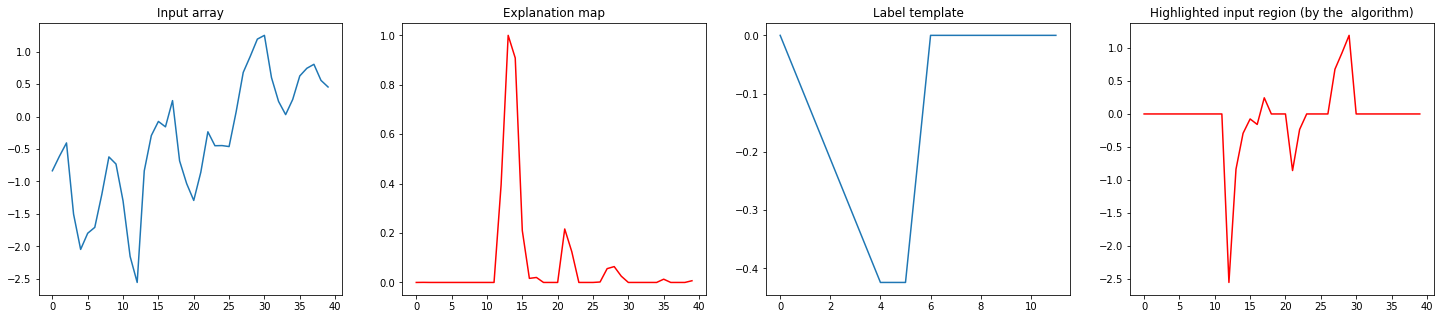


Correct digit: 5
Predicted digit: 5
Confidence score for the correct label: 0.99988234


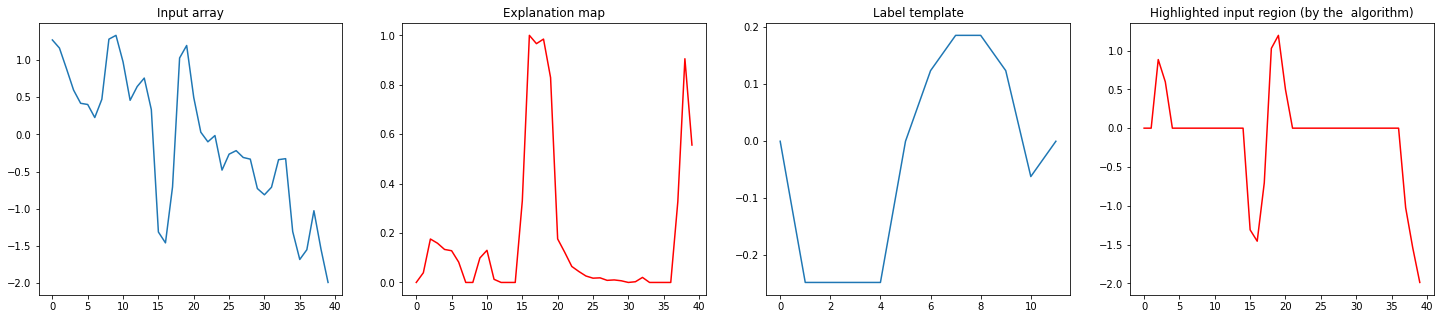


Correct digit: 6
Predicted digit: 6
Confidence score for the correct label: 1.0


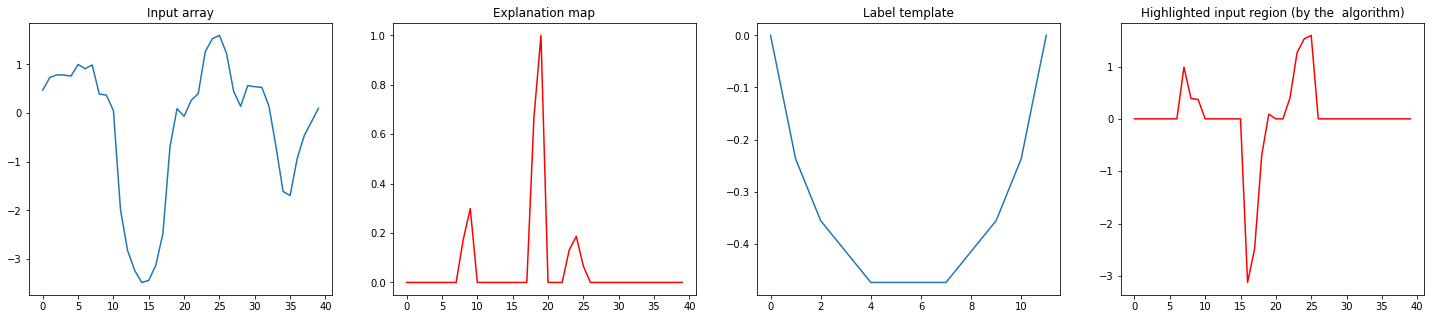


Correct digit: 7
Predicted digit: 7
Confidence score for the correct label: 0.9999479


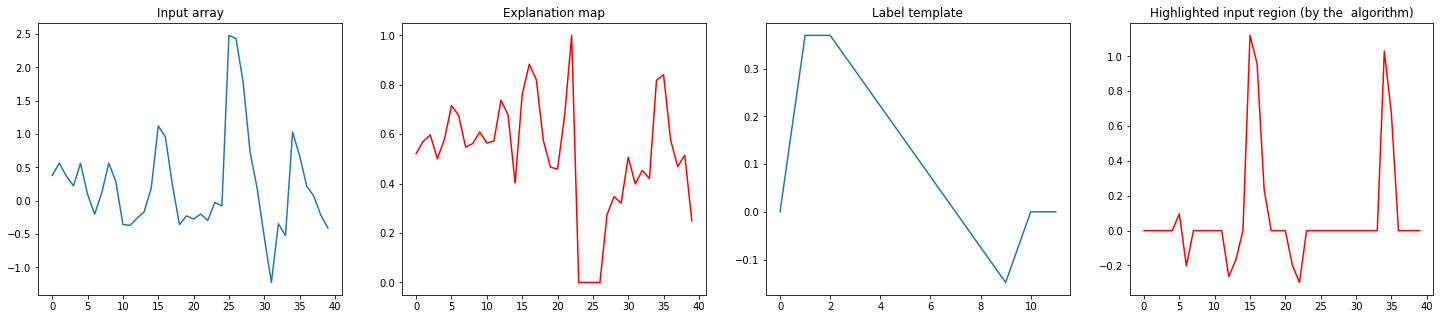


Correct digit: 8
Predicted digit: 8
Confidence score for the correct label: 0.99221766


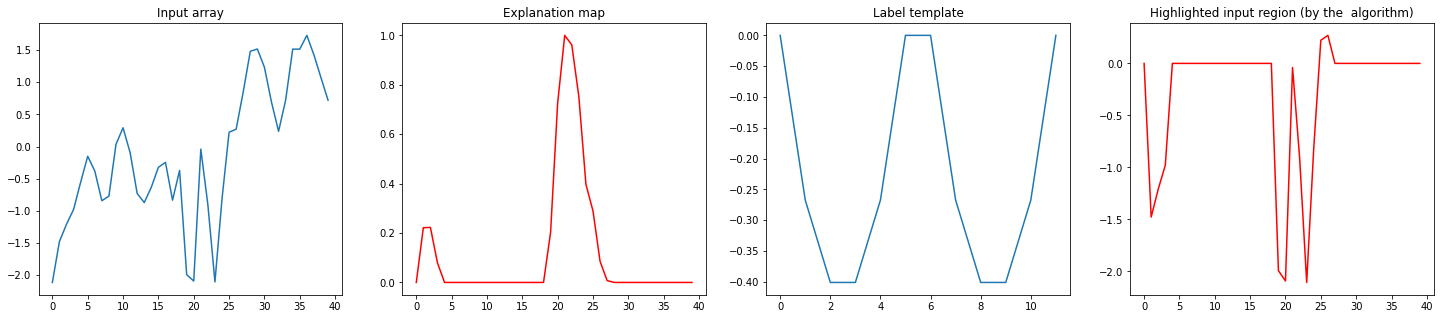


Correct digit: 9
Predicted digit: 2
Confidence score for the correct label: 0.21103819


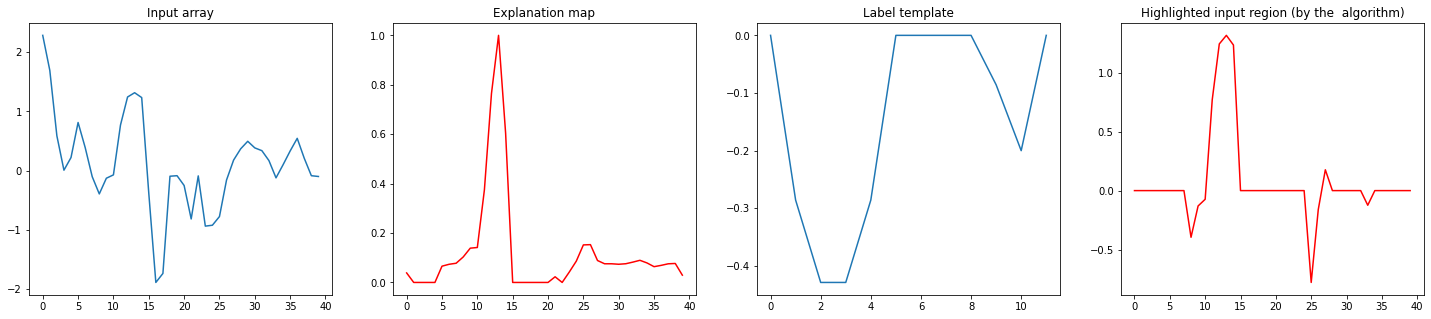

In [ ]:
### 1-dimensional explanation map of 10 different labels
for i in range(10):

  ## Obtain the first index that y_test is equal to the class i
  index = np.where(y_test == i)[0][0]

  input = np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)
  label = y_test[index]
  print('\nCorrect digit: '+str(label))
  print('Predicted digit: '+str(np.argmax(model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy())))
  print('Confidence score for the correct label: '+str(model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy()[0,label]))
  
  explanation = grad_cam(model, input, 'conv1d_2')

  threshold = np.sort(explanation)[-12]

  plt.figure(figsize=(25,5))

  plt.subplot(1,4,1)
  plt.plot(input[0])
  plt.title('Input array')

  plt.subplot(1,4,2)
  plt.plot(explanation, 'r')
  plt.title('Explanation map')

  plt.subplot(1,4,3)
  plt.plot(dataset['templates']['x'][label])
  plt.title('Label template')

  plt.subplot(1,4,4)
  plt.plot((input[0,:,0]*(explanation>threshold)), 'r')
  plt.title('Highlighted input region (by the  algorithm)')

  plt.show()


Correct digit: 0
Predicted digit: 0
Confidence score for the correct label: 0.7611122

Correct digit: 1
Predicted digit: 9
Confidence score for the correct label: 0.0020318

Correct digit: 2
Predicted digit: 2
Confidence score for the correct label: 0.97238916

Correct digit: 3
Predicted digit: 3
Confidence score for the correct label: 1.0

Correct digit: 4
Predicted digit: 4
Confidence score for the correct label: 0.98805517

Correct digit: 5
Predicted digit: 5
Confidence score for the correct label: 0.99988234

Correct digit: 6
Predicted digit: 6
Confidence score for the correct label: 1.0

Correct digit: 7
Predicted digit: 7
Confidence score for the correct label: 0.9999479

Correct digit: 8
Predicted digit: 8
Confidence score for the correct label: 0.99221766

Correct digit: 9
Predicted digit: 2
Confidence score for the correct label: 0.21103819


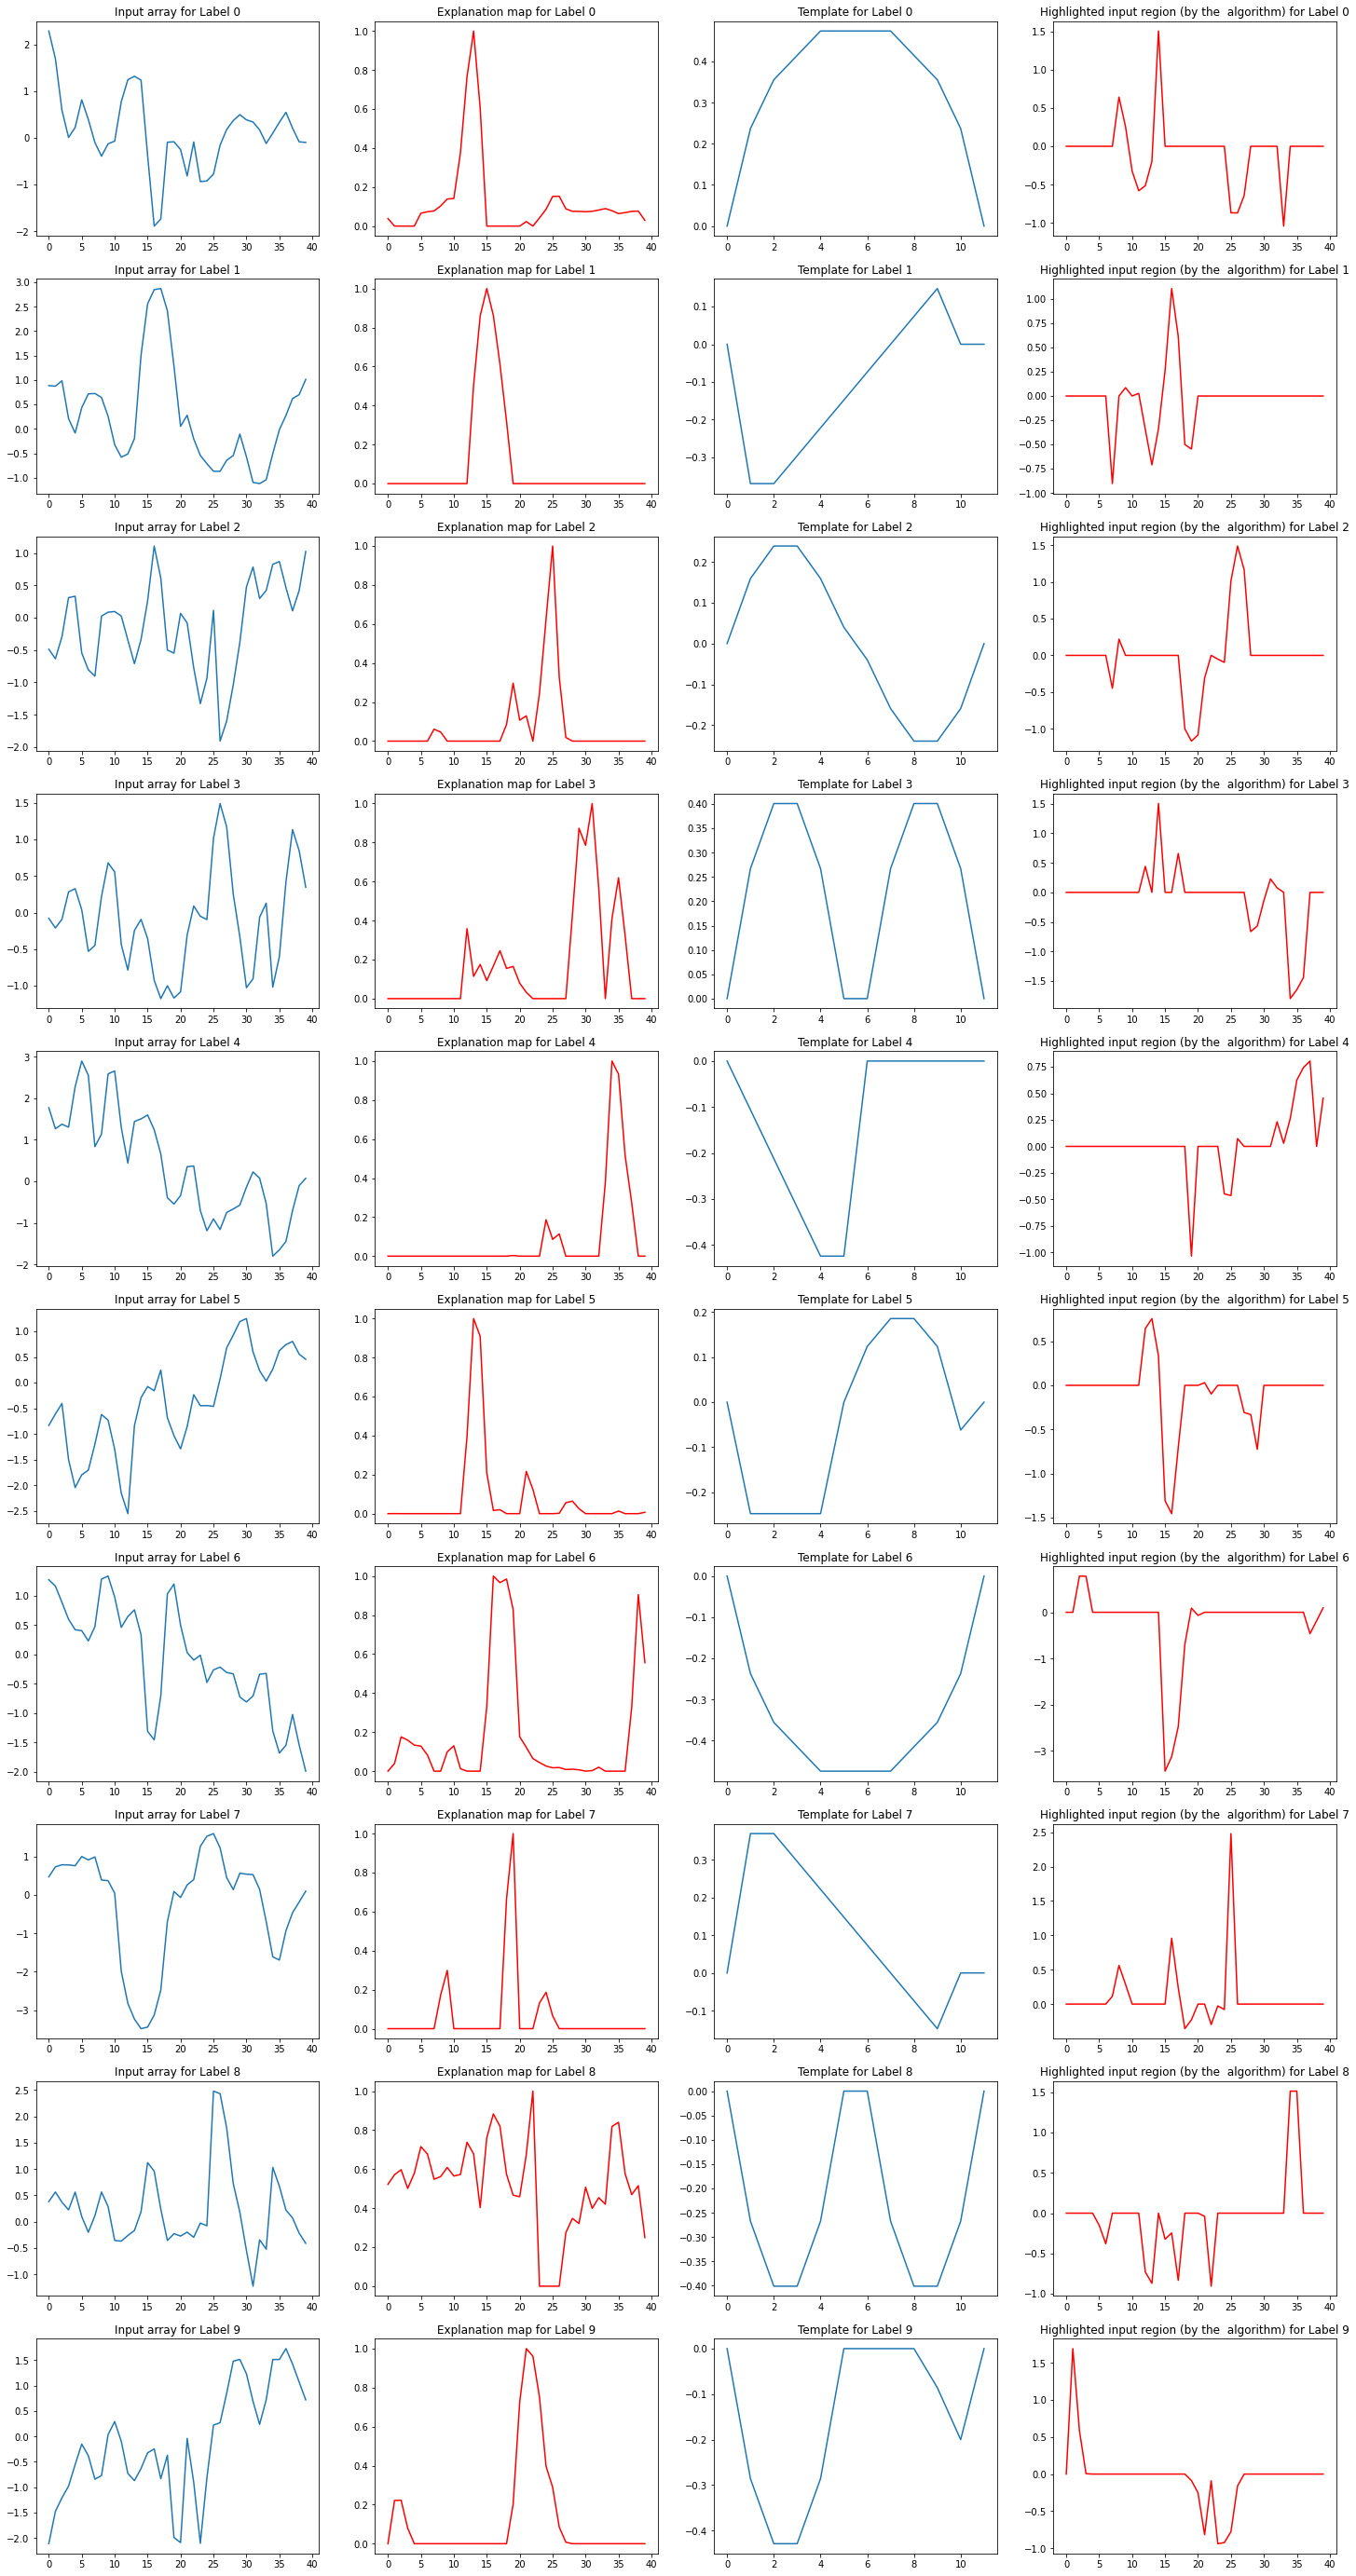

In [ ]:
plt.figure(figsize=(25,50))
### 1-dimensional explanation map of 10 different labels
for i in range(10):

  ## Obtain the first index that y_test is equal to the class i
  index = np.where(y_test == i)[0][0]
  label = y_test[index]
  print('\nCorrect digit: '+str(label))
  print('Predicted digit: '+str(np.argmax(model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy())))
  print('Confidence score for the correct label: '+str(model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy()[0,label]))
  
  explanation = grad_cam(model, input, 'conv1d_2')

  threshold = np.sort(explanation)[-12]

  plt.subplot(10,4,4*i+1)
  plt.plot(input[0])
  plt.title('Input array for Label %d' %(label))

  plt.subplot(10,4,4*i+2)
  plt.plot(explanation, 'r')
  plt.title('Explanation map for Label %d' %(label))

  plt.subplot(10,4,4*i+3)
  plt.plot(dataset['templates']['x'][label])
  plt.title('Template for Label %d' %(label))
  input = np.expand_dims(np.expand_dims(dataset['x_test'][index], axis=0), axis=-1)
  plt.subplot(10,4,4*i+4)
  plt.plot((input[0,:,0]*(explanation>threshold)), 'r')
  plt.title('Highlighted input region (by the  algorithm) for Label %d' %(label))

plt.savefig('Explaination Map Minist-1 GradCam.svg')
plt.show()

**Model 2: LIME**

Modified from Github: https://github.com/marcotcr/lime/blob/master/lime/lime_tabular.py

In [ ]:
!pip install lime

     |████████████████████████████████| 275 kB 6.7 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=e45bbf68cb728dfbf1d4827d1fc3a951799b172a0e75c7cd4e8fcd82a16b5255
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [ ]:
import lime
from lime.lime_tabular import LimeTabularExplainer

In [ ]:
def Lime(x):
  explainer = LimeTabularExplainer(dataset['x'], mode="classification", random_state=0)

  predict_fn = lambda x: model.predict(x)

  score_list = []

  explanation = explainer.explain_instance(x_test[x], predict_fn)
  
  local_exp = explanation.local_exp[1]


  local_exp = sorted(local_exp,key=lambda x: x[0])


  local_exp = np.array(local_exp)

  for feat, score in local_exp:
    score_list.append(score)


  H = 40

  score_list = np.array(score_list)

  score_list = zoom(score_list,H/score_list.shape[0])

  score_list = np.maximum(score_list, 0)

  score_list = score_list / score_list.max()

  return score_list
#explanation.show_in_notebook(show_all=True)


Correct digit: 0
Predicted digit: 0
Confidence score for the correct label: 0.7611122


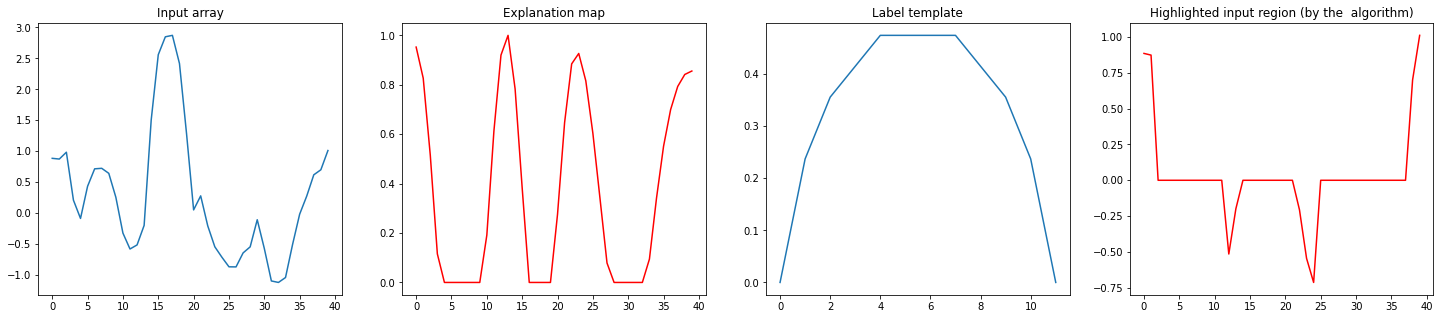


Correct digit: 1
Predicted digit: 9
Confidence score for the correct label: 0.0020318


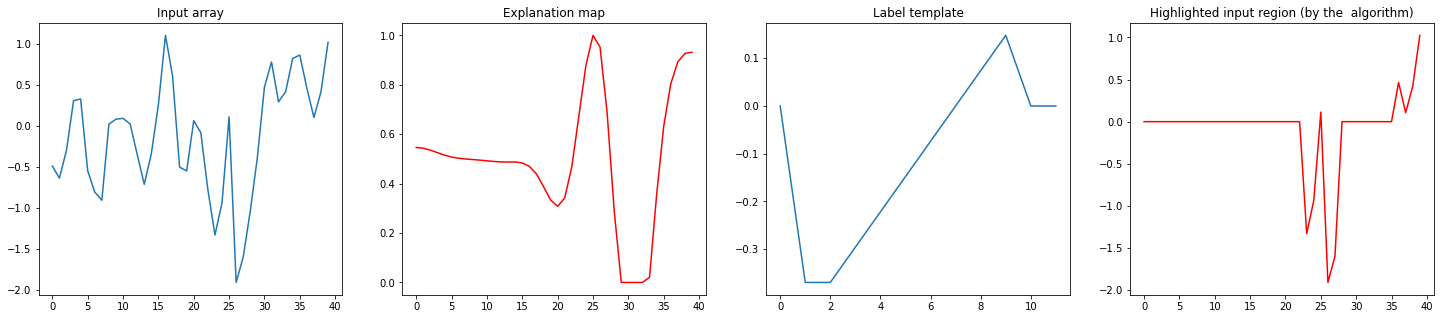


Correct digit: 2
Predicted digit: 2
Confidence score for the correct label: 0.97238916


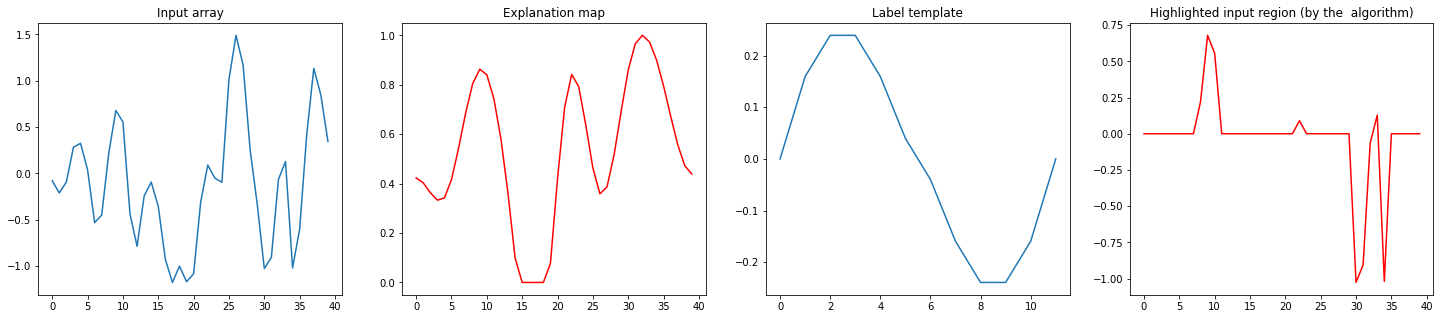


Correct digit: 3
Predicted digit: 3
Confidence score for the correct label: 1.0


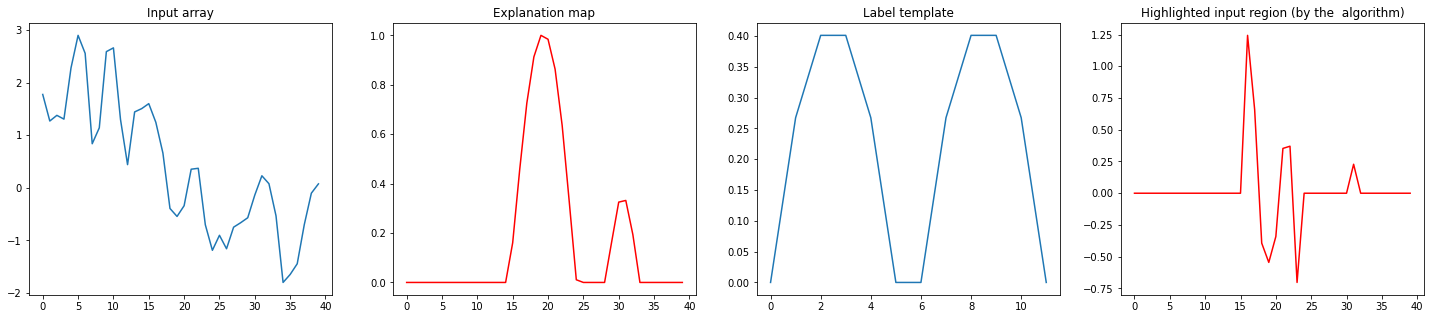


Correct digit: 4
Predicted digit: 4
Confidence score for the correct label: 0.98805517


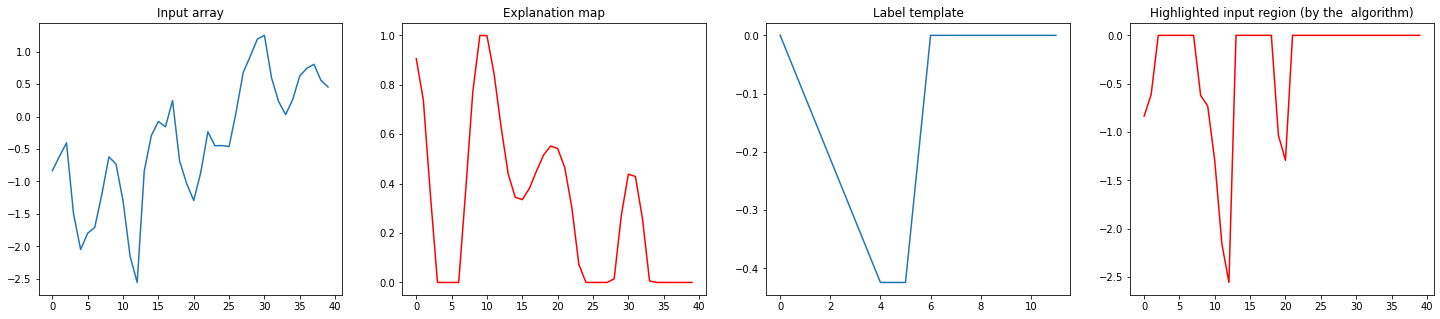


Correct digit: 5
Predicted digit: 5
Confidence score for the correct label: 0.99988234


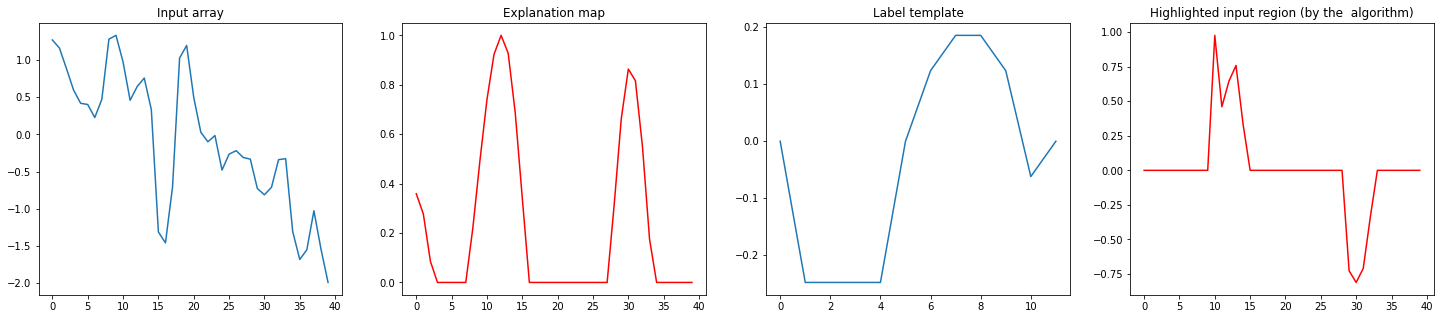


Correct digit: 6
Predicted digit: 6
Confidence score for the correct label: 1.0


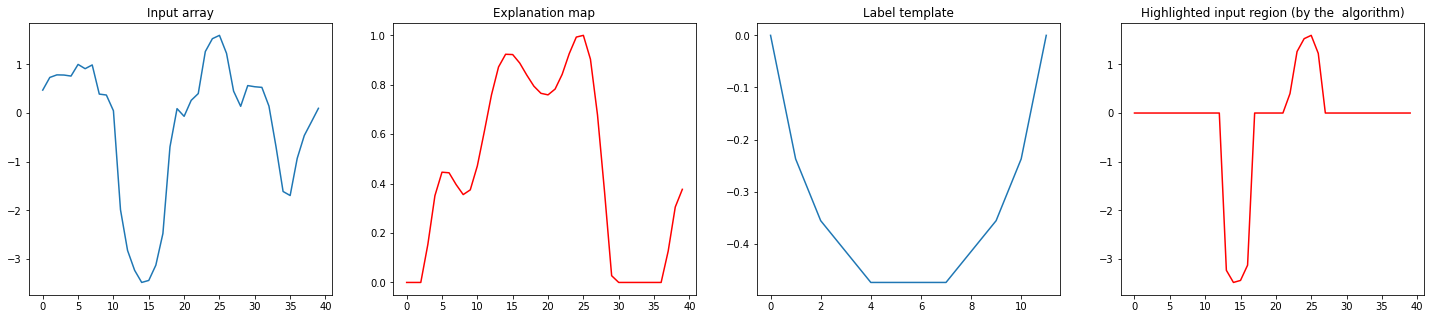


Correct digit: 7
Predicted digit: 7
Confidence score for the correct label: 0.9999479


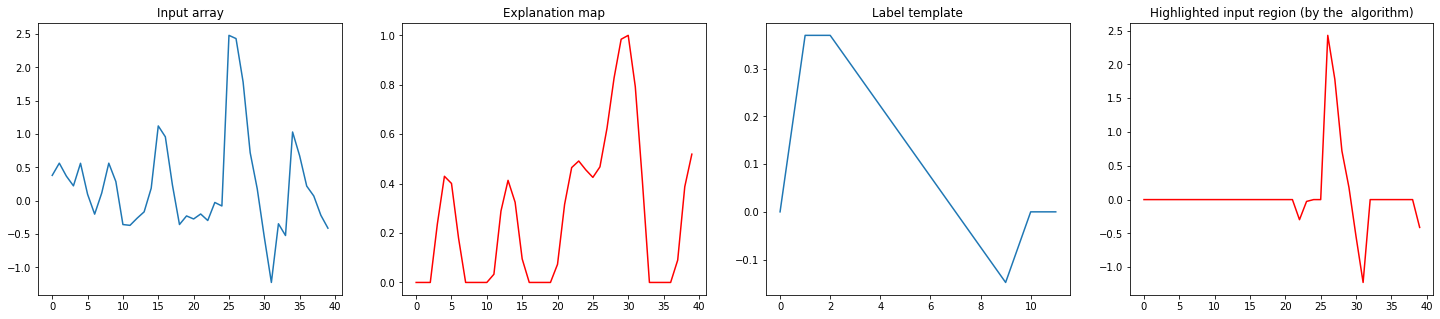


Correct digit: 8
Predicted digit: 8
Confidence score for the correct label: 0.99221766


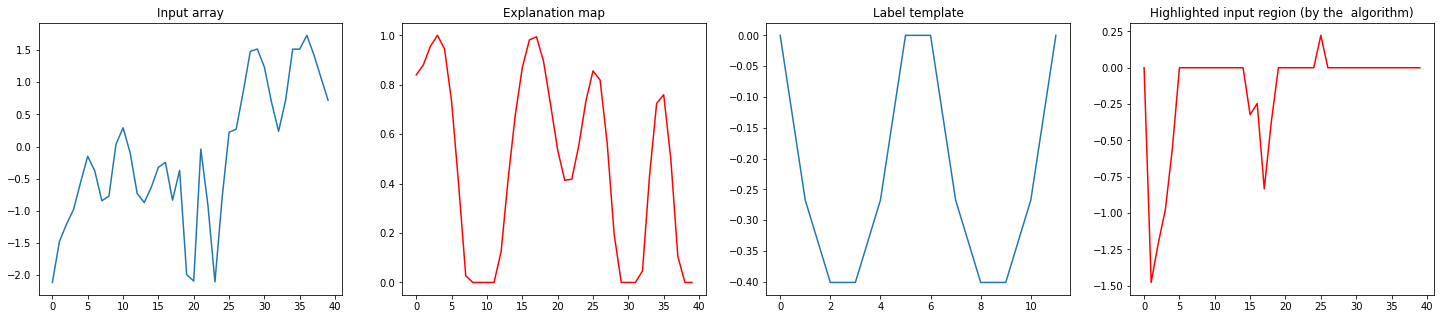


Correct digit: 9
Predicted digit: 2
Confidence score for the correct label: 0.21103819


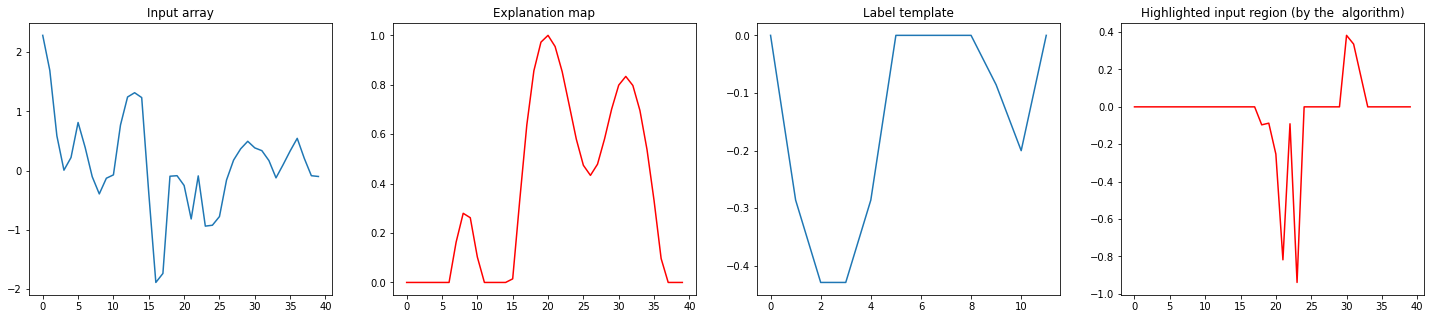

In [ ]:
### 1-dimensional explanation map of 10 different labels
for i in range(10):

  ## Obtain the first index that y_test is equal to the class i
  index = np.where(y_test == i)[0][0]
  label = y_test[index]
  print('\nCorrect digit: '+str(label))
  print('Predicted digit: '+str(np.argmax(model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy())))
  print('Confidence score for the correct label: '+str(model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy()[0,label]))
  
  explanation = Lime(index)

  threshold = np.sort(explanation)[-10]

  plt.figure(figsize=(25,5))

  plt.subplot(1,4,1)
  plt.plot(x_test[index])
  plt.title('Input array')

  plt.subplot(1,4,2)
  plt.plot(explanation, 'r')
  plt.title('Explanation map')

  plt.subplot(1,4,3)
  plt.plot(dataset['templates']['x'][label])
  plt.title('Label template')

  plt.subplot(1,4,4)
  plt.plot((x_test[index]*(explanation>threshold)), 'r')

  plt.title('Highlighted input region (by the  algorithm)')

  plt.show()

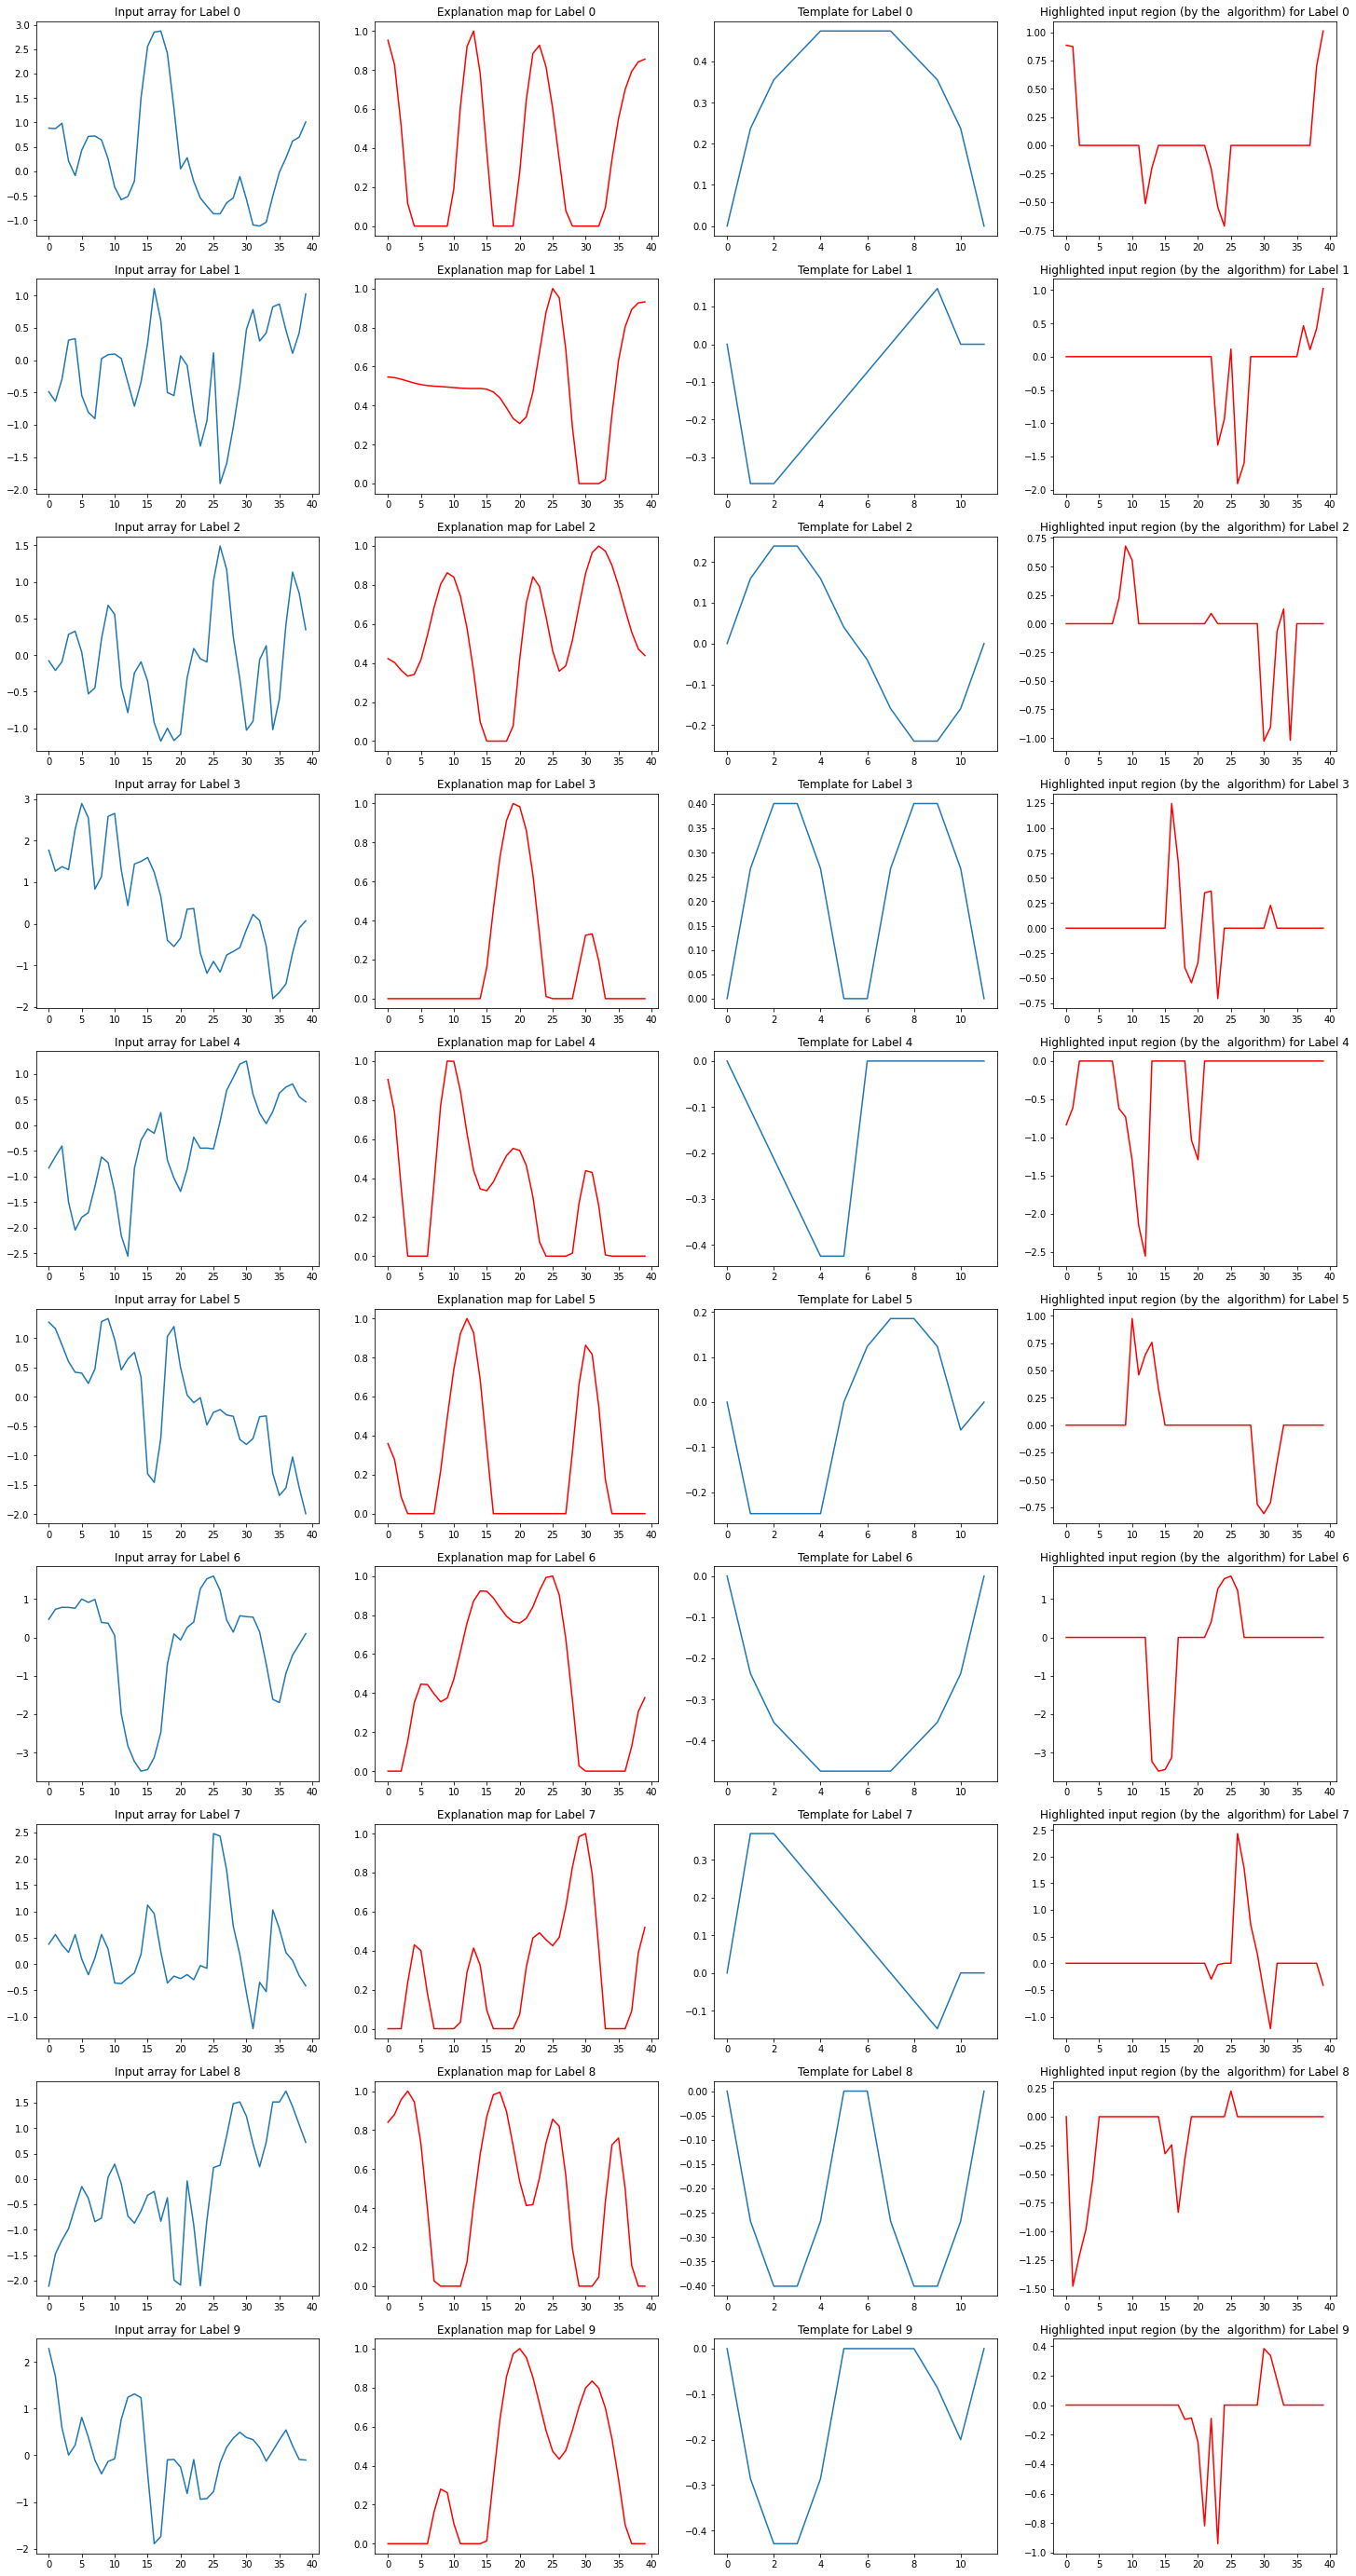

In [ ]:
### 1-dimensional explanation map of 10 different labels
plt.figure(figsize=(25,50))

for i in range(10):

  ## Obtain the first index that y_test is equal to the class i
  index = np.where(y_test == i)[0][0]

  input = np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)
  label = y_test[index]
  
  explanation = Lime(index)

  threshold = np.sort(explanation)[-10]

  plt.subplot(10,4,4*i+1)
  plt.plot(input[0])
  plt.title('Input array for Label %d' %(label))

  plt.subplot(10,4,4*i+2)
  plt.plot(explanation, 'r')
  plt.title('Explanation map for Label %d' %(label))

  plt.subplot(10,4,4*i+3)
  plt.plot(dataset['templates']['x'][label])
  plt.title('Template for Label %d' %(label))
  input = np.expand_dims(np.expand_dims(dataset['x_test'][index], axis=0), axis=-1)
  plt.subplot(10,4,4*i+4)
  plt.plot((input[0,:,0]*(explanation>threshold)), 'r')
  plt.title('Highlighted input region (by the  algorithm) for Label %d' %(label))

plt.savefig('Explaination Map Minist-1 Lime.svg')
plt.show()

**Method 3: Integrated Gradients**

In [ ]:
# Adapted From https://keras.io/examples/vision/integrated_gradients/

def get_img_array(img_path, size=(299, 299)):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def get_gradients(img_input, top_pred_idx):
    """Computes the gradients of outputs w.r.t input image.

    Args:
        img_input: 4D image tensor
        top_pred_idx: Predicted label for the input image

    Returns:
        Gradients of the predictions w.r.t img_input
    """
    images = tf.cast(img_input, tf.float32)
    #images = tf.convert_to_tensor(img_input)
    with tf.GradientTape() as tape:
        tape.watch(images)
        preds = model(images)
        top_class = preds[:, top_pred_idx]

    grads = tape.gradient(top_class, images)
    return grads


def get_integrated_gradients(img_input, top_pred_idx, baseline=None, num_steps=50):
    """Computes Integrated Gradients for a predicted label.

    Args:
        img_input (ndarray): Original image
        top_pred_idx: Predicted label for the input image
        baseline (ndarray): The baseline image to start with for interpolation
        num_steps: Number of interpolation steps between the baseline
            and the input used in the computation of integrated gradients. These
            steps along determine the integral approximation error. By default,
            num_steps is set to 50.

    Returns:
        Integrated gradients w.r.t input image
    """
    # If baseline is not provided, start with a black image
    # having same size as the input image.
    img_size = (40,)
    if baseline is None:
        baseline = np.zeros(img_size).astype(np.float32)
    else:
        baseline = baseline.astype(np.float32)

    # 1. Do interpolation.
    img_input = img_input.astype(np.float32)
    interpolated_image = [
        baseline + (step / num_steps) * (img_input - baseline)
        for step in range(num_steps + 1)
    ]
    interpolated_image = np.array(interpolated_image).astype(np.float32)

    # 3. Get the gradients
    grads = []
    for i, img in enumerate(interpolated_image):
        img = tf.expand_dims(img, axis=0)
        grad = get_gradients(img, top_pred_idx=top_pred_idx)
        grads.append(grad[0])
    grads = tf.convert_to_tensor(grads, dtype=tf.float32)

    # 4. Approximate the integral using the trapezoidal rule
    grads = (grads[:-1] + grads[1:]) / 2.0
    avg_grads = tf.reduce_mean(grads, axis=0)

    # 5. Calculate integrated gradients and return
    integrated_grads = (img_input - baseline) * avg_grads
    return integrated_grads


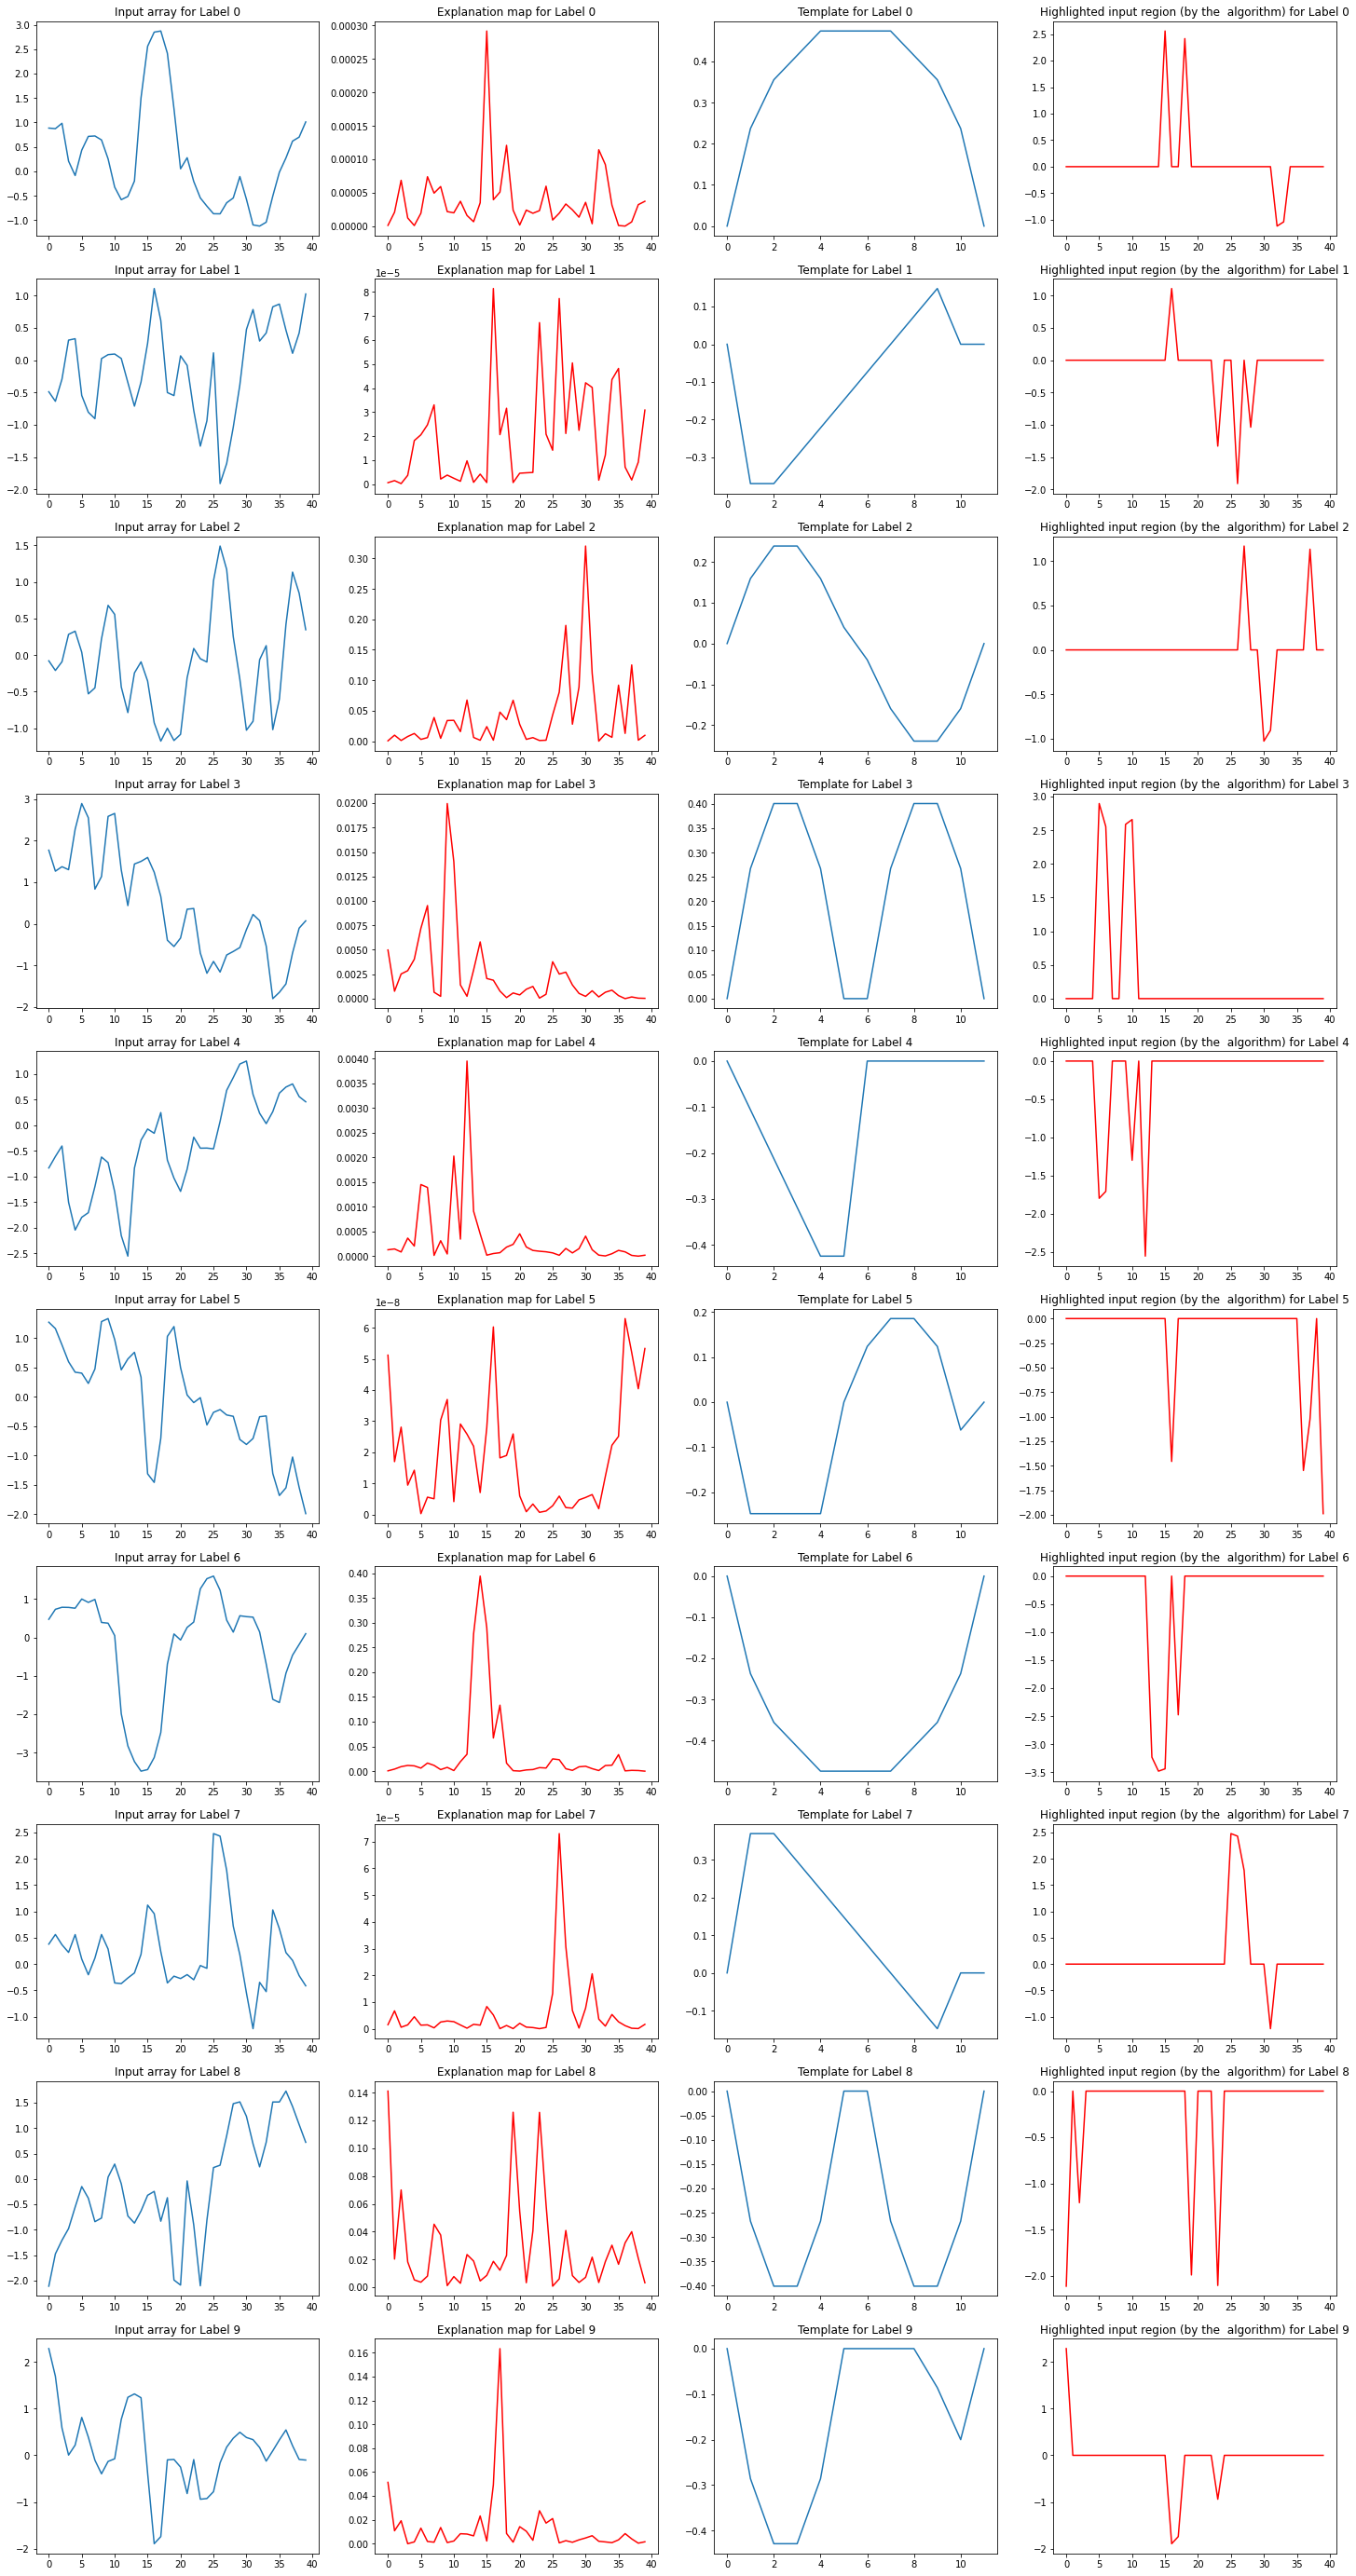

In [ ]:
### 1-dimensional explanation map of 10 different label
plt.figure(figsize=(25,50))
for i in range(10):

  ## Obtain the first index that y_test is equal to the class i
  index = np.where(dataset['y_test'] == i)[0][0]

  input = np.expand_dims(np.expand_dims(dataset['x_test'][index], axis=0), axis=-1)
  label = dataset['y_test'][index]
  #print('\nCorrect digit: '+str(label))
  #print('Predicted digit: '+str(np.argmax(model(np.expand_dims(np.expand_dims(dataset['x_test'][index], axis=0), axis=-1)).numpy())))
  #print('Confidence score for the correct label: '+str(model(np.expand_dims(np.expand_dims(dataset['x_test'][index], axis=0), axis=-1)).numpy()[0,label]))
  
  input = np.expand_dims(dataset['x_test'][index],axis = 0)

  preds = model.predict(np.expand_dims(dataset['x'][index],axis = 0))
  top_pred_idx = tensorflow.argmax(preds[0])


  igrads = get_integrated_gradients(
      dataset['x_test'][index], top_pred_idx=top_pred_idx, num_steps=50
  )

  explanation  = np.abs(igrads)
  threshold = np.sort(explanation)[-5]

  plt.subplot(10,4,4*i+1)
  plt.plot(input[0])
  plt.title('Input array for Label %d' %(label))

  plt.subplot(10,4,4*i+2)
  plt.plot(explanation, 'r')
  plt.title('Explanation map for Label %d' %(label))

  plt.subplot(10,4,4*i+3)
  plt.plot(dataset['templates']['x'][label])
  plt.title('Template for Label %d' %(label))
  input = np.expand_dims(np.expand_dims(dataset['x_test'][index], axis=0), axis=-1)
  plt.subplot(10,4,4*i+4)
  plt.plot((input[0,:,0]*(explanation>threshold)), 'r')
  plt.title('Highlighted input region (by the  algorithm) for Label %d' %(label))

plt.savefig('Explaination Map Minist-1 IG.svg')
plt.show()

#### Task 2-2-b:
Qualitatively report the explanation maps you achieved and compare them with the templates presented for each of the digits. Discuss your results. Do you think the highlighted region is similar to the template corresponding to the digit predicted by your model? Do you think the explanation map shows the local behavior of the model well?

## Task4: Quantitative evaluation of the attribution methods

### Task4-1:
Apply the “Drop%” and “Increase%” metrics to evaluate the performance of your selected
attribution methods when applied to the CNN trained on both datasets. For the MNIST-1D dataset, take the parameter “k” shown in Figure 2 as 30%. This parameter can be tuned using the input argument frac in the function calculate_drop_increase(). Take this parameter for the HMT dataset as 90%. For both datasets, calculate the average drop% and average increase% on the whole test set.

In [ ]:
def calculate_drop_increase(images, model, exmap, class_index, frac=0.15):
    '''
    inputs:
        images: a 4-D image of size (1 x H x W x 3)
          containing an image in RGB format and of size (H x W)
        model: The base model
        exmap: a given explanation map whose completeness is to be evaluated.
        class_index: The class to whom the explanation map is related to.
        frac: The fraction of top pixels selected.
    returns:v
        a tuple with 4 calculates values:
        (drop, increase, original_pred, eplanation_pred)
        drop (float): drop rate (between 0 and 1)
        increase (boolean): "1" if increase happened
        original_pred: confidence score for original image
        explanation_pred:  confidence score for the selected top pixels of the image.
    '''
    predictions = model.predict(images)
    #print(images.shape)
    # Pre-processing image 
    img=images[0,:,:]
    #img=img_to_array(img)
    img = np.expand_dims(img,axis=0)
    # Getting the prediction for image
    # Class probability
    Y=predictions[0][class_index]
    
    grad_array=np.reshape(exmap, (-1,))
    array_size=int(grad_array.shape[0]*frac)
    thr=np.flip(sorted(grad_array))[array_size]
    exmap1_msk=(exmap>thr)
    exmap1_thr=np.zeros(shape=(1,40,1))
    exmap1_thr=img*exmap1_msk
    ex_predictions = model.predict(exmap1_thr)[0]
    O1=ex_predictions[class_index]
    etta=(Y-O1)/(Y+1e-100)
    return (etta*(etta>0), 1*(etta<0), Y, O1)

In [ ]:
# Method 1: Grad-CAM
drop_rate = 0.
increase_rate = 0.
for index in range(1000):
  input = np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)
  prediction=model(input).numpy()
  explanation_map = grad_cam(model, input, 'conv1d_2')
  explanation_map = np.expand_dims(explanation_map, axis=-1)
  drop, increase, _, _= calculate_drop_increase(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1), model, explanation_map, class_index=np.argmax(prediction[0]), frac=0.3)
  drop_rate += drop
  increase_rate += increase
drop_rate /= 1000
increase_rate /= 1000

print('Method 1: Grad-CAM')
print('Drop rate: %.3f' %(drop_rate))
print('Increase rate: %.3f' %(increase_rate))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


Method 1: Grad-CAM
Drop rate: 0.432
Increase rate: 0.325


In [ ]:
# Method 2: Integrated Gradient
drop_rate = 0.
increase_rate = 0.
for index in range(1000):
  input = np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)
  prediction=model(input).numpy()
  top_pred_idx = tensorflow.argmax(preds[0])
  prediction=model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy()
  igrads = get_integrated_gradients(
  dataset['x_test'][index], top_pred_idx=top_pred_idx, num_steps=50
)
  explanation_map    = np.abs(igrads)
  explanation_map = np.expand_dims(explanation_map, axis=-1)
  drop, increase, _, _= calculate_drop_increase(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1), model, explanation_map, class_index=np.argmax(prediction[0]), frac=0.3)
  drop_rate += drop
  increase_rate += increase
drop_rate /= 1000
increase_rate /= 1000

print('Method 2: Integrated Gradient')
print('Drop rate: %.3f'%(drop_rate))
print('Increase rate: %.3f'%(increase_rate))

Method 2: Integrated Gradient
Drop rate: 0.337
Increase rate: 0.240


In [ ]:
# Method 3: LIME
drop_rate = 0.
increase_rate = 0.
for index in range(1000):
  prediction=model(input).numpy()
  explanation_map = Lime(index)
  explanation_map = np.expand_dims(explanation_map, axis=-1)
  drop, increase, _, _= calculate_drop_increase(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1), model, explanation_map, class_index=np.argmax(prediction[0]), frac=0.3)
  drop_rate += drop
  increase_rate += increase

drop_rate /= 1000
increase_rate /= 1000

print('Method 3: LIME')
print('Drop rate: %.3f' %(drop_rate))
print('Increase rate: %.3f' %(increase_rate))

Method 3: LIME
Drop rate: 0.206
Increase rate: 0.747
